In [1]:
library(corrplot)
library(tidyverse)
library(ggplot2)
#install.packages('plotly')
library(plotly)
library(car)
#install.packages('caTools')
library(caTools)
library(caret)
#install.packages('glmnet')
library(glmnet)
library(pROC)
library(vip)

corrplot 0.95 loaded

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required pa

# Cleaning & Data Validation

In [2]:
df<-read.csv("~/Desktop/full_kpop_data.csv")
head(df)

,X,track_name,artist,duration_ms,album,release_date,popularity,associated_kpop_group,spotify_track_id,artist_id,⋯,user_playlist_count,which_user_playlists,company,big4,gender,debut,days_since_release,age_days,collab,playlist_exposure
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,0,My Universe,Coldplay,226198,Music Of The Spheres,2021-10-15,79,BTS,46HNZY1i7O6jwTA7Slo2PI,3Nrfpe0tUJi4K4DXYWgMUX,⋯,0,0,Big Hit Music,1,M,2013-06-13,1387,4433,1,0
2,1,Dynamite,BTS,199053,BE,2020-11-20,81,BTS,5QDLhrAOJJdNAmCTJ8xMyW,3Nrfpe0tUJi4K4DXYWgMUX,⋯,0,0,Big Hit Music,1,M,2013-06-13,1716,4433,0,0
3,2,FAKE LOVE,BTS,242333,Love Yourself 轉 'Tear',2018-05-18,80,BTS,6m1TWFMeon7ai9XLOzdbiR,3Nrfpe0tUJi4K4DXYWgMUX,⋯,0,0,Big Hit Music,1,M,2013-06-13,2633,4433,0,0
4,3,Permission to Dance - Live,BTS,279286,PERMISSION TO DANCE ON STAGE - LIVE,2025-07-18,82,BTS,4UAnQaQTSMjKjHkqjKwEYx,3Nrfpe0tUJi4K4DXYWgMUX,⋯,0,0,Big Hit Music,1,M,2013-06-13,15,4433,0,0
5,4,Boy With Luv (feat. Halsey),BTS,229773,MAP OF THE SOUL : PERSONA,2019-04-12,79,BTS,4a9tbd947vo9K8Vti9JwcI,3Nrfpe0tUJi4K4DXYWgMUX,⋯,1,5YZ5U9DAUd71CIwj55A49D,Big Hit Music,1,M,2013-06-13,2304,4433,0,1
6,5,Left and Right (Feat. Jung Kook of BTS),Charlie Puth,154486,CHARLIE,2022-10-06,75,BTS,0mBP9X2gPCuapvpZ7TGDk3,6HaGTQPmzraVmaVxvz6EUc,⋯,0,0,Big Hit Music,1,M,2013-06-13,1031,4433,1,0


In [3]:
df<-df[,-c(1)]

In [4]:
glimpse(df)

Rows: 269
Columns: 22
$ track_name            <chr> "My Universe", "Dynamite", "FAKE LOVE", "Permiss…
$ artist                <chr> "Coldplay", "BTS", "BTS", "BTS", "BTS", "Charlie…
$ duration_ms           <int> 226198, 199053, 242333, 279286, 229773, 154486, …
$ album                 <chr> "Music Of The Spheres", "BE", "Love Yourself 轉 '…
$ release_date          <chr> "2021-10-15", "2020-11-20", "2018-05-18", "2025-…
$ popularity            <int> 79, 81, 80, 82, 79, 75, 77, 78, 77, 75, 96, 78, …
$ associated_kpop_group <chr> "BTS", "BTS", "BTS", "BTS", "BTS", "BTS", "BTS",…
$ spotify_track_id      <chr> "46HNZY1i7O6jwTA7Slo2PI", "5QDLhrAOJJdNAmCTJ8xMy…
$ artist_id             <chr> "3Nrfpe0tUJi4K4DXYWgMUX", "3Nrfpe0tUJi4K4DXYWgMU…
$ artist_followers      <int> 80103753, 80103753, 80103753, 80103753, 80103753…
$ artist_popularity     <int> 90, 90, 90, 90, 90, 84, 90, 90, 90, 90, 87, 87, …
$ artist_genres         <chr> "k-pop", "k-pop", "k-pop", "k-pop", "k-pop", "k-…
$ user_playlist_co

## Validation:

1. **Unique artist ids** --> ensure we're picking up the correct kpop artist information
2. **Unique track ids** --> again ensure we've not only picked up the correct track information but also that we do not double count any observations
3. **Check Logic A** --> validate that numeric scores stay [0-100] and that categorical variables that have integer responses stay [0,1]
4. **Check Logic B** --> Confirm user_playlist_counts and playlist_exposure match up correctly

### **1. Unique Artist ID**

In [5]:
#there are 27 k-pop groups
length(unique(df$artist_id))
## clearly we picked up different things

[1] 30

In [6]:
a<-c(unique(df$artist_id))
b<-c('3Nrfpe0tUJi4K4DXYWgMUX','41MozSoPIsD1dJM0CLPjZF','7nqOGRxlXj7N2JYbgNEjYH','2dIgFjalVxs4ThymZ67YCE','7f4ignuCJhLXfZ9giKT7rH',
        '1gBUSTR3TyDdTVFIaQnc02','5t5FqBwTcgKTaWmfEbwQY9','0ghlgldX5Dd6720Q3qFyQB','6HvZYsbFfjnjFrWF950C9d','6RHTUrRF63xao58xh9FXYJ',
        '2KC9Qb60EaY0kW4eH68vr3', '2AfmfGFbe0A0WsTYm0SDTx','68KmkJeZGfwe1OUaivBa2L','4SpbR6yFEvexJuaBpgAU5p','1z4g3DjTBBZKhvAroFlhOM',
        '3cjEqqelV9zb4BYE3qDQ4O','2hRQKC0gqlZGPrmUKbcchR','01XYiBYaoMJcNhPokrg0l0','1SIocsqdEefUTE6XKGUiVS','4hnHLgMSOiqERWBL4jINP1',
        '6QHP8St0MzfNDqjKpwtMht','28ot3wh4oNmoFOdVajibBl','5R7AMwDeroq6Ls0COQYpS4', '6FkhUhUwSPl3mGB6mmE8wn','2GQxKDojobwBjZMPf7aoh0',
        '5GwQwY63I9hrUUFlQB8FYU','2jOm3cYujQx6o1dxuiuqaX')

setdiff(a,b)

[1] "6HaGTQPmzraVmaVxvz6EUc" "20DZAfCuP1TKZl5KcY7z3Q" "4AK6F7OLvEQ5QYCBNiQWHq"

In [7]:
id<- df$artist_id %in% c('6HaGTQPmzraVmaVxvz6EUc', '20DZAfCuP1TKZl5KcY7z3Q','4AK6F7OLvEQ5QYCBNiQWHq')

df[id,c('track_name','artist','associated_kpop_group','artist_id','artist_followers','artist_popularity','artist_genres')] 

,track_name,artist,associated_kpop_group,artist_id,artist_followers,artist_popularity,artist_genres
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
6,Left and Right (Feat. Jung Kook of BTS),Charlie Puth,BTS,6HaGTQPmzraVmaVxvz6EUc,18077404,84,k-pop
30,Love Is Gone (with JOSHUA of SEVENTEEN),SLANDER,SEVENTEEN,20DZAfCuP1TKZl5KcY7z3Q,578309,68,"melodic bass, edm, future bass, dubstep"
116,MORE,K/DA,i-dle,4AK6F7OLvEQ5QYCBNiQWHq,39951258,87,0


In [8]:
head(df[df$associated_kpop_group=='BTS',c('track_name','artist','associated_kpop_group','artist_id','artist_followers','artist_popularity','artist_genres')],1)

,track_name,artist,associated_kpop_group,artist_id,artist_followers,artist_popularity,artist_genres
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,My Universe,Coldplay,BTS,3Nrfpe0tUJi4K4DXYWgMUX,80103753,90,k-pop


In [9]:
head(df[df$associated_kpop_group=='SEVENTEEN',c('track_name','artist','associated_kpop_group','artist_id','artist_followers','artist_popularity','artist_genres')],1)

,track_name,artist,associated_kpop_group,artist_id,artist_followers,artist_popularity,artist_genres
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
21,THUNDER,SEVENTEEN,SEVENTEEN,7nqOGRxlXj7N2JYbgNEjYH,13440876,82,k-pop


In [10]:
# there are definitely more k/da songs associated with i-dle so I wonder if k/da has multiple artist ids
# or maybe it picked up a different secondary artist
df[df$associated_kpop_group=='i-dle',c('track_name','artist','associated_kpop_group','artist_id','artist_followers','artist_popularity','artist_genres')]

,track_name,artist,associated_kpop_group,artist_id,artist_followers,artist_popularity,artist_genres
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
111,Queencard,i-dle,i-dle,2AfmfGFbe0A0WsTYm0SDTx,10796451,75,k-pop
112,Good Thing,i-dle,i-dle,2AfmfGFbe0A0WsTYm0SDTx,10796451,75,k-pop
113,POP/STARS,K/DA,i-dle,2AfmfGFbe0A0WsTYm0SDTx,10796451,75,k-pop
114,TOMBOY,i-dle,i-dle,2AfmfGFbe0A0WsTYm0SDTx,10796451,75,k-pop
115,Nxde,i-dle,i-dle,2AfmfGFbe0A0WsTYm0SDTx,10796451,75,k-pop
116,MORE,K/DA,i-dle,4AK6F7OLvEQ5QYCBNiQWHq,39951258,87,0
117,THE BADDEST,K/DA,i-dle,2AfmfGFbe0A0WsTYm0SDTx,10796451,75,k-pop
118,Super Lady,i-dle,i-dle,2AfmfGFbe0A0WsTYm0SDTx,10796451,75,k-pop
119,Wife,i-dle,i-dle,2AfmfGFbe0A0WsTYm0SDTx,10796451,75,k-pop


In [11]:
##fix the 3 rows

#BTS
df[6,'artist_id']='3Nrfpe0tUJi4K4DXYWgMUX'
df[6,'artist_followers']=80103753	
df[6,'artist_popularity']=90

#SEVENTEEN
df[30,'artist_id']='7nqOGRxlXj7N2JYbgNEjYH'
df[30,'artist_followers']=13440876
df[30,'artist_popularity']=82
df[30,'artist_genres']='k-pop'

#i-dle
df[116,'artist_id']='2AfmfGFbe0A0WsTYm0SDTx'
df[116,'artist_followers']=10796451
df[116,'artist_popularity']=75
df[116,'artist_genres']='k-pop'

#check that it populated correctly
df[id,c('track_name','artist','associated_kpop_group','artist_id','artist_followers','artist_popularity','artist_genres')] 


,track_name,artist,associated_kpop_group,artist_id,artist_followers,artist_popularity,artist_genres
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
6,Left and Right (Feat. Jung Kook of BTS),Charlie Puth,BTS,3Nrfpe0tUJi4K4DXYWgMUX,80103753,90,k-pop
30,Love Is Gone (with JOSHUA of SEVENTEEN),SLANDER,SEVENTEEN,7nqOGRxlXj7N2JYbgNEjYH,13440876,82,k-pop
116,MORE,K/DA,i-dle,2AfmfGFbe0A0WsTYm0SDTx,10796451,75,k-pop


In [12]:
#double check kpop groups
length(unique(df$associated_kpop_group))

[1] 27

### **2. Unique Track ID**

In [13]:
nrow(df)

[1] 269

In [14]:
length(unique(df$spotify_track_id))

[1] 269

### **3. Check Logic**

In [15]:
summary(df[,c('popularity','artist_popularity','user_playlist_count','big4','collab','playlist_exposure')])
#Everything falls into the expect 0-100 or 0-1 range

   popularity    artist_popularity user_playlist_count      big4       
 Min.   :33.00   Min.   :48.00     Min.   :0.0000      Min.   :0.0000  
 1st Qu.:57.00   1st Qu.:65.00     1st Qu.:0.0000      1st Qu.:0.0000  
 Median :67.00   Median :72.00     Median :0.0000      Median :1.0000  
 Mean   :64.83   Mean   :71.59     Mean   :0.2342      Mean   :0.5948  
 3rd Qu.:75.00   3rd Qu.:82.00     3rd Qu.:0.0000      3rd Qu.:1.0000  
 Max.   :96.00   Max.   :90.00     Max.   :8.0000      Max.   :1.0000  
     collab        playlist_exposure
 Min.   :0.00000   Min.   :0.0000   
 1st Qu.:0.00000   1st Qu.:0.0000   
 Median :0.00000   Median :0.0000   
 Mean   :0.02602   Mean   :0.1264   
 3rd Qu.:0.00000   3rd Qu.:0.0000   
 Max.   :1.00000   Max.   :1.0000   

In [16]:
#double check that playlist exposure aligns with only lower playlist count 
#and those with >0 playlsit count are counted in plylsit exposure
unique(df[,c('user_playlist_count','playlist_exposure')])

,user_playlist_count,playlist_exposure
,<int>,<int>
1,0,0
5,1,1
12,2,1
15,3,1
113,6,1
151,8,1


## Cleaning:

In [17]:
str(df)

'data.frame':	269 obs. of  22 variables:
 $ track_name           : chr  "My Universe" "Dynamite" "FAKE LOVE" "Permission to Dance - Live" ...
 $ artist               : chr  "Coldplay" "BTS" "BTS" "BTS" ...
 $ duration_ms          : int  226198 199053 242333 279286 229773 154486 164952 204939 207481 223122 ...
 $ album                : chr  "Music Of The Spheres" "BE" "Love Yourself 轉 'Tear'" "PERMISSION TO DANCE ON STAGE - LIVE" ...
 $ release_date         : chr  "2021-10-15" "2020-11-20" "2018-05-18" "2025-07-18" ...
 $ popularity           : int  79 81 80 82 79 75 77 78 77 75 ...
 $ associated_kpop_group: chr  "BTS" "BTS" "BTS" "BTS" ...
 $ spotify_track_id     : chr  "46HNZY1i7O6jwTA7Slo2PI" "5QDLhrAOJJdNAmCTJ8xMyW" "6m1TWFMeon7ai9XLOzdbiR" "4UAnQaQTSMjKjHkqjKwEYx" ...
 $ artist_id            : chr  "3Nrfpe0tUJi4K4DXYWgMUX" "3Nrfpe0tUJi4K4DXYWgMUX" "3Nrfpe0tUJi4K4DXYWgMUX" "3Nrfpe0tUJi4K4DXYWgMUX" ...
 $ artist_followers     : num  80103753 80103753 80103753 80103753 80103753 ...
 $

### **Double Checking some of the Collabs**

Collaborations as indicated by title did not get picked up in the initial extraction as those different main artists. Will likely need to add additional logic to pick up additional artists in the future to fix

In [18]:
df$track_name

[1] "My Universe"                                             
  [2] "Dynamite"                                                
  [3] "FAKE LOVE"                                               
  [4] "Permission to Dance - Live"                              
  [5] "Boy With Luv (feat. Halsey)"                             
  [6] "Left and Right (Feat. Jung Kook of BTS)"                 
  [7] "Butter"                                                  
  [8] "Run BTS"                                                 
  [9] "Life Goes On"                                            
 [10] "DNA"                                                     
 [11] "JUMP"                                                    
 [12] "Pink Venom"                                              
 [13] "Shut Down"                                               
 [14] "Kill This Love"                                          
 [15] "How You Like That"                                       
 [16] "As If It's Your Last"                                    
 [17] "DDU-DU DDU-DU"                                           
 [18] "BOOMBAYAH"                                               
 [19] "Lovesick Girls"                                          
 [20] "Pretty Savage"                                           
 [21] "THUNDER"                                                 
 [22] "LOVE, MONEY, FAME (feat. DJ Khaled)"                     
 [23] "Super"                                                   
 [24] "HOT"                                                     
 [25] "Rock with you"                                           
 [26] "VERY NICE"                                               
 [27] "MAESTRO"                                                 
 [28] "Bad Influence (Prod. by Pharrell Williams)"              
 [29] "HBD"                                                     
 [30] "Love Is Gone (with JOSHUA of SEVENTEEN)"                 
 [31] "Chk Chk Boom"                                            
 [32] "Hollow"                                                  
 [33] "LALALALA"                                                
 [34] "God’s Menu"                                              
 [35] "MANIAC"                                                  
 [36] "S-Class"                                                 
 [37] "I Like It"                                               
 [38] "Walkin On Water"                                         
 [39] "Come Play (from the series Arcane League of Legends)"    
 [40] "MEGAVERSE"                                               
 [41] "Fact Check"                                              
 [42] "Kick It"                                                 
 [43] "Walk"                                                    
 [44] "Cherry Bomb"                                             
 [45] "2 Baddies"                                               
 [46] "Favorite (Vampire)"                                      
 [47] "Sticker"                                                 
 [48] "Whiplash"                                                
 [49] "Regular - English Version"                               
 [50] "Lemonade"                                                
 [51] "CHILLER"                                                 
 [52] "BTTF"                                                    
 [53] "When I'm With You"                                       
 [54] "I LIKE IT"                                               
 [55] "DREAM TEAM"                                              
 [56] "Candy"                                                   
 [57] "’Bout You"                                               
 [58] "Don’t Need Your Love"                                    
 [59] "BOOM"                                                    
 [60] "Broken Melodies"                                         
 [61] "Bad Desire (With or Without You)"                        
 [62] "Bite Me"                      

In [19]:
df[df$collab==1,]


,track_name,artist,duration_ms,album,release_date,popularity,associated_kpop_group,spotify_track_id,artist_id,artist_followers,⋯,user_playlist_count,which_user_playlists,company,big4,gender,debut,days_since_release,age_days,collab,playlist_exposure
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,My Universe,Coldplay,226198,Music Of The Spheres,2021-10-15,79,BTS,46HNZY1i7O6jwTA7Slo2PI,3Nrfpe0tUJi4K4DXYWgMUX,80103753,⋯,0,0,Big Hit Music,1,M,2013-06-13,1387,4433,1,0
6,Left and Right (Feat. Jung Kook of BTS),Charlie Puth,154486,CHARLIE,2022-10-06,75,BTS,0mBP9X2gPCuapvpZ7TGDk3,3Nrfpe0tUJi4K4DXYWgMUX,80103753,⋯,0,0,Big Hit Music,1,M,2013-06-13,1031,4433,1,0
30,Love Is Gone (with JOSHUA of SEVENTEEN),SLANDER,178285,Love Is Gone (with JOSHUA of SEVENTEEN),2025-07-25,69,SEVENTEEN,4FTcJ9B6S2QXObqRr9UG8U,7nqOGRxlXj7N2JYbgNEjYH,13440876,⋯,0,0,Pledis Entertainment,1,M,2015-05-26,8,3721,1,0
74,butterflies (feat. TAEHYUN & Kim Chaewon of LE SSERAFIM),JVKE,164466,butterflies (feat. TAEHYUN of TOMORROW X TOGETHER & Kim Chaewon of LE SSERAFIM),2025-07-10,78,TOMORROW X TOGETHER,0VdikQbDdOqxdWQyYsLmne,0ghlgldX5Dd6720Q3qFyQB,11690744,⋯,0,0,Big Hit Music,1,M,2019-03-04,23,2343,1,0
113,POP/STARS,K/DA,191100,POP/STARS,2018-11-03,74,i-dle,5sbooPcNgIE22DwO0VNGUJ,2AfmfGFbe0A0WsTYm0SDTx,10796451,⋯,6,"4DO9jHccZGtGKAMmFNsIir,6fQ3H7MipHCbzVazbPyHhQ,5EPJPyctDDc1omacvILCsu,4TaZDRINJ2lgsFLHQ8Vplx,0QQ54WssFuO3tiOBLU1xRw,1a8TABtuIO69BgFdmY17Ht",Cube Entertainment,0,F,2018-05-18,2464,2633,1,1
116,MORE,K/DA,217088,MORE,2020-10-28,70,i-dle,0UAB340gAcSMk3r0a8PTag,2AfmfGFbe0A0WsTYm0SDTx,10796451,⋯,0,0,Cube Entertainment,0,F,2018-05-18,1739,2633,1,0
117,THE BADDEST,K/DA,162600,THE BADDEST,2020-08-27,68,i-dle,2V4Fx72svQRxrFvNT1eq5f,2AfmfGFbe0A0WsTYm0SDTx,10796451,⋯,2,"5EPJPyctDDc1omacvILCsu,4TaZDRINJ2lgsFLHQ8Vplx",Cube Entertainment,0,F,2018-05-18,1801,2633,1,1


In [20]:
#there are in fact more collabs as indicated by title than originally included
#but not all those originally indicated as collabs
# may need to investigate the artists section again
df[c(1,5,6,22,28,30,39,74,113,116,117),]

,track_name,artist,duration_ms,album,release_date,popularity,associated_kpop_group,spotify_track_id,artist_id,artist_followers,⋯,user_playlist_count,which_user_playlists,company,big4,gender,debut,days_since_release,age_days,collab,playlist_exposure
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,My Universe,Coldplay,226198,Music Of The Spheres,2021-10-15,79,BTS,46HNZY1i7O6jwTA7Slo2PI,3Nrfpe0tUJi4K4DXYWgMUX,80103753,⋯,0,0,Big Hit Music,1,M,2013-06-13,1387,4433,1,0
5,Boy With Luv (feat. Halsey),BTS,229773,MAP OF THE SOUL : PERSONA,2019-04-12,79,BTS,4a9tbd947vo9K8Vti9JwcI,3Nrfpe0tUJi4K4DXYWgMUX,80103753,⋯,1,5YZ5U9DAUd71CIwj55A49D,Big Hit Music,1,M,2013-06-13,2304,4433,0,1
6,Left and Right (Feat. Jung Kook of BTS),Charlie Puth,154486,CHARLIE,2022-10-06,75,BTS,0mBP9X2gPCuapvpZ7TGDk3,3Nrfpe0tUJi4K4DXYWgMUX,80103753,⋯,0,0,Big Hit Music,1,M,2013-06-13,1031,4433,1,0
22,"LOVE, MONEY, FAME (feat. DJ Khaled)",SEVENTEEN,186386,"LOVE, MONEY, FAME (feat. DJ Khaled) (Timbaland Remix)",2024-11-01,66,SEVENTEEN,145tqlcE6YFsjNfxi9K3AE,7nqOGRxlXj7N2JYbgNEjYH,13440876,⋯,0,0,Pledis Entertainment,1,M,2015-05-26,274,3721,0,0
28,Bad Influence (Prod. by Pharrell Williams),SEVENTEEN,167013,SEVENTEEN 5th Album 'HAPPY BURSTDAY',2025-05-26,70,SEVENTEEN,6uJlw4VHZulMvz6s3J2bO2,7nqOGRxlXj7N2JYbgNEjYH,13440876,⋯,0,0,Pledis Entertainment,1,M,2015-05-26,68,3721,0,0
30,Love Is Gone (with JOSHUA of SEVENTEEN),SLANDER,178285,Love Is Gone (with JOSHUA of SEVENTEEN),2025-07-25,69,SEVENTEEN,4FTcJ9B6S2QXObqRr9UG8U,7nqOGRxlXj7N2JYbgNEjYH,13440876,⋯,0,0,Pledis Entertainment,1,M,2015-05-26,8,3721,1,0
39,Come Play (from the series Arcane League of Legends),Stray Kids,161666,Come Play (from the series Arcane League of Legends),2024-10-16,75,Stray Kids,2K7g8dvwkIGgPEYKivmatN,2dIgFjalVxs4ThymZ67YCE,19852655,⋯,0,0,JYP Entertainment,1,F,2018-03-25,290,2687,0,0
74,butterflies (feat. TAEHYUN & Kim Chaewon of LE SSERAFIM),JVKE,164466,butterflies (feat. TAEHYUN of TOMORROW X TOGETHER & Kim Chaewon of LE SSERAFIM),2025-07-10,78,TOMORROW X TOGETHER,0VdikQbDdOqxdWQyYsLmne,0ghlgldX5Dd6720Q3qFyQB,11690744,⋯,0,0,Big Hit Music,1,M,2019-03-04,23,2343,1,0
113,POP/STARS,K/DA,191100,POP/STARS,2018-11-03,74,i-dle,5sbooPcNgIE22DwO0VNGUJ,2AfmfGFbe0A0WsTYm0SDTx,10796451,⋯,6,"4DO9jHccZGtGKAMmFNsIir,6fQ3H7MipHCbzVazbPyHhQ,5EPJPyctDDc1omacvILCsu,4TaZDRINJ2lgsFLHQ8Vplx,0QQ54WssFuO3tiOBLU1xRw,1a8TABtuIO69BgFdmY17Ht",Cube Entertainment,0,F,2018-05-18,2464,2633,1,1


In [21]:
df[c(1,5,6,22,28,30,39,74,113,116,117),'collab']=1
df[c(1,5,6,22,28,30,39,74,113,116,117),'collab']

[1] 1 1 1 1 1 1 1 1 1 1 1

### **List Variables**

Options for how to treat these as we cannot continue as is:
- dummy coding them
- feature extraction
- ignoring them

I think that for `which_user_playlists`, since we already have the variable with total playlist inclusion counts (i.e. feature extraction), we can probably just not use this but for `artist_genres` it may be useful to dummy code it.



In [22]:
unique(df$artist_genres)

[1] "k-pop"                      "k-pop, noise music"        
[3] "noise music, k-pop, k-rock"

In [23]:
#df[df$artist_genres=='k-pop, noise music',]
df[df$artist_genres=='noise music, k-pop, k-rock',]


,track_name,artist,duration_ms,album,release_date,popularity,associated_kpop_group,spotify_track_id,artist_id,artist_followers,⋯,user_playlist_count,which_user_playlists,company,big4,gender,debut,days_since_release,age_days,collab,playlist_exposure
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>
200,TRICKY HOUSE,xikers,184769,HOUSE OF TRICKY : Doorbell Ringing,2023-03-30,56,xikers,2MeEPaL5HsW9njvrtP0Agj,6QHP8St0MzfNDqjKpwtMht,465220,⋯,0,0,KQ Entertainment,0,M,2023-03-30,856,856,0,0
201,BREATHE,xikers,183080,HOUSE OF TRICKY : SPUR,2025-04-04,56,xikers,2P5bbp7BeVtrECPJaN8AFO,6QHP8St0MzfNDqjKpwtMht,465220,⋯,0,0,KQ Entertainment,0,M,2023-03-30,120,856,0,0
202,Up All Night,xikers,215667,Up All Night,2025-07-13,48,xikers,2652PzGxxU8jzARLLubmjD,6QHP8St0MzfNDqjKpwtMht,465220,⋯,0,0,KQ Entertainment,0,M,2023-03-30,20,856,0,0
203,Red Sun,xikers,204724,HOUSE OF TRICKY : Trial And Error,2024-03-08,47,xikers,3z3eX1eG1Gj0YFDhYPkTrl,6QHP8St0MzfNDqjKpwtMht,465220,⋯,0,0,KQ Entertainment,0,M,2023-03-30,512,856,0,0
204,WITCH,xikers,195520,HOUSE OF TRICKY : WATCH OUT,2024-09-06,46,xikers,336bNqFkCC2owApr6l7osT,6QHP8St0MzfNDqjKpwtMht,465220,⋯,0,0,KQ Entertainment,0,M,2023-03-30,330,856,0,0
205,ROCKSTAR,xikers,193223,HOUSE OF TRICKY : Doorbell Ringing,2023-03-30,46,xikers,34St2IIfAjXcb18wVUYd3x,6QHP8St0MzfNDqjKpwtMht,465220,⋯,0,0,KQ Entertainment,0,M,2023-03-30,856,856,0,0
206,You Hide We Seek,xikers,200360,HOUSE OF TRICKY : SPUR,2025-04-04,45,xikers,6djhkFwzJAF1gHxohYooDf,6QHP8St0MzfNDqjKpwtMht,465220,⋯,0,0,KQ Entertainment,0,M,2023-03-30,120,856,0,0
207,DO or DIE,xikers,210811,HOUSE OF TRICKY : HOW TO PLAY,2023-08-02,45,xikers,6brb7SXjhqHOxsj0jkyQVH,6QHP8St0MzfNDqjKpwtMht,465220,⋯,0,0,KQ Entertainment,0,M,2023-03-30,731,856,0,0
208,XIKEY,xikers,208618,HOUSE OF TRICKY : Doorbell Ringing,2023-03-30,44,xikers,4cSe8fDRrmCnYmuG7KvQVe,6QHP8St0MzfNDqjKpwtMht,465220,⋯,0,0,KQ Entertainment,0,M,2023-03-30,856,856,0,0


In [24]:
#dummy code genre variables
df <- df %>%
  mutate(
    genre_kpop = as.integer(str_detect(artist_genres, "k-pop")),
    genre_noise_music = as.integer(str_detect(artist_genres, "noise music")),
    genre_k_rock = as.integer(str_detect(artist_genres, "k-rock"))
  )

In [25]:

#df[df$artist_genres=='noise music, k-pop, k-rock',c('artist_genres','genre_kpop','genre_noise_music','genre_k_rock')]
head(df[df$artist_genres=='k-pop, noise music',c('artist_genres','genre_kpop','genre_noise_music','genre_k_rock')])

,artist_genres,genre_kpop,genre_noise_music,genre_k_rock
,<chr>,<int>,<int>,<int>
31,"k-pop, noise music",1,1,0
32,"k-pop, noise music",1,1,0
33,"k-pop, noise music",1,1,0
34,"k-pop, noise music",1,1,0
35,"k-pop, noise music",1,1,0
36,"k-pop, noise music",1,1,0


# Where are we now:

In [26]:
str(df)

'data.frame':	269 obs. of  25 variables:
 $ track_name           : chr  "My Universe" "Dynamite" "FAKE LOVE" "Permission to Dance - Live" ...
 $ artist               : chr  "Coldplay" "BTS" "BTS" "BTS" ...
 $ duration_ms          : int  226198 199053 242333 279286 229773 154486 164952 204939 207481 223122 ...
 $ album                : chr  "Music Of The Spheres" "BE" "Love Yourself 轉 'Tear'" "PERMISSION TO DANCE ON STAGE - LIVE" ...
 $ release_date         : chr  "2021-10-15" "2020-11-20" "2018-05-18" "2025-07-18" ...
 $ popularity           : int  79 81 80 82 79 75 77 78 77 75 ...
 $ associated_kpop_group: chr  "BTS" "BTS" "BTS" "BTS" ...
 $ spotify_track_id     : chr  "46HNZY1i7O6jwTA7Slo2PI" "5QDLhrAOJJdNAmCTJ8xMyW" "6m1TWFMeon7ai9XLOzdbiR" "4UAnQaQTSMjKjHkqjKwEYx" ...
 $ artist_id            : chr  "3Nrfpe0tUJi4K4DXYWgMUX" "3Nrfpe0tUJi4K4DXYWgMUX" "3Nrfpe0tUJi4K4DXYWgMUX" "3Nrfpe0tUJi4K4DXYWgMUX" ...
 $ artist_followers     : num  80103753 80103753 80103753 80103753 80103753 ...
 $

# EDA / Visualizations

## correlations

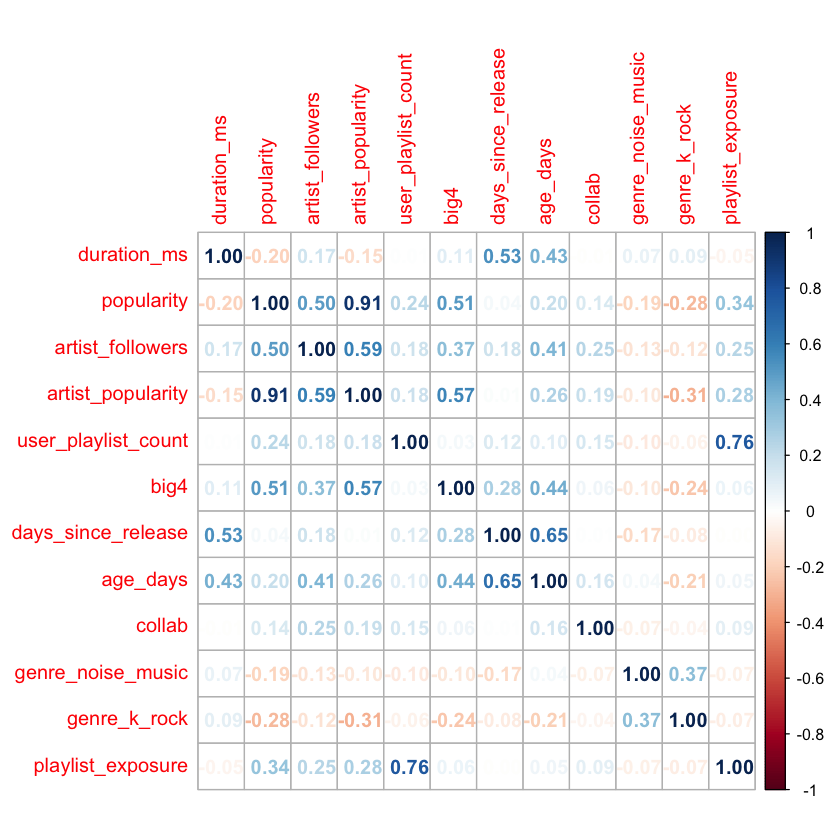

In [27]:
#won't include genre kpop as every row is nonzero
num<- df[ ,c(3,6,10,11,13,16,19,20,21,24,25,22)]

corr<-cor(num)
corrplot(corr,method='number')

0.91 - popularity x artist_popularity

0.76 - user_playlist_count x playlist_exposure
<- cut this out for log reg

0.65 - age_days x days_since_release

### data types

In [28]:
# setting type now for future use

#strings: track_name, artist, album,associated_kpop_group, company,artist_id,
#unlikely to be used: which_user_playlists,artist_genres

#categorical
df$gender<-as.factor(df$gender)
df$big4<-as.factor(df$big4)
df$collab<-as.factor(df$collab)
df$genre_kpop<-as.factor(df$genre_kpop)#though its all 1's
df$genre_noise_music<-as.factor(df$genre_noise_music)
df$genre_k_rock<-as.factor(df$genre_k_rock)

#date -- as they are already in the default form
df$release_date<-as.Date(df$release_date)
df$debut<-as.Date(df$debut)

#integers/mumeric: duration_ms,popularity,artist_followers,artist_popularity,user_playlist_count

#target 
df$playlist_exposure<-as.factor(df$playlist_exposure)

## EDA

In [29]:
tapply(df$popularity, df$playlist_exposure, summary) 

$`0`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  33.00   56.00   66.00   63.26   72.50   85.00 

$`1`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  62.00   73.25   77.50   75.62   80.00   96.00 


In [30]:
tapply(df$artist_popularity, df$playlist_exposure, summary) 

$`0`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  48.00   64.00   71.00   70.34   81.00   90.00 

$`1`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  63.00   75.00   81.50   80.24   87.00   90.00 


In [31]:
tapply(df$duration_ms, df$playlist_exposure, summary) 

$`0`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 108986  169714  187226  186892  201769  314866 

$`1`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 138108  167945  184714  183325  193744  240793 


In [32]:
tapply(df$age_days, df$playlist_exposure, summary) 

$`0`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    488    1257    1724    2299    3272    6275 

$`1`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    488    2343    2554    2528    3281    4864 


### Background on Playlist_Exposure

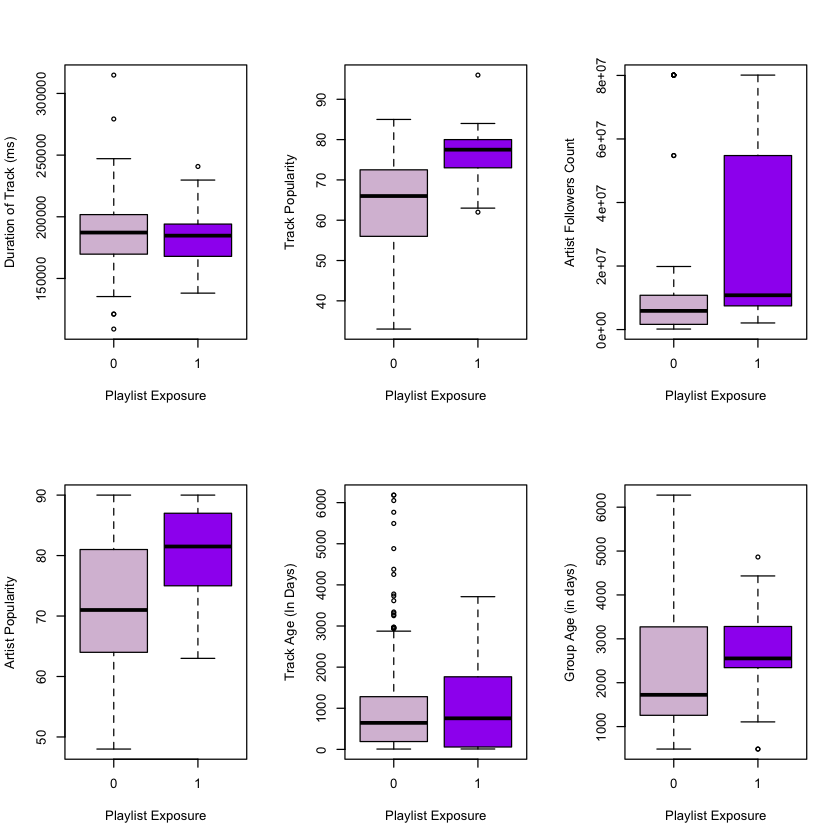

In [33]:
par(mfrow = c(2, 3))

boxplot(duration_ms~ playlist_exposure, main="", xlab="Playlist Exposure",
        ylab="Duration of Track (ms)", col=c("thistle","purple"), data=df)
boxplot(popularity~ playlist_exposure, main="", xlab="Playlist Exposure",
        ylab="Track Popularity", col=c("thistle","purple"), data=df)
boxplot(artist_followers~ playlist_exposure, main="", xlab="Playlist Exposure",
        ylab="Artist Followers Count", col=c("thistle","purple"), data=df)
boxplot(artist_popularity~ playlist_exposure, main="", xlab="Playlist Exposure",
        ylab="Artist Popularity", col=c("thistle","purple"), data=df)
boxplot(days_since_release~ playlist_exposure, main="", xlab="Playlist Exposure",
        ylab="Track Age (In Days)", col=c("thistle","purple"), data=df)
boxplot(age_days~ playlist_exposure, main="", xlab="Playlist Exposure",
        ylab="Group Age (in days)", col=c("thistle","purple"), data=df)

In [34]:
x<-as.data.frame(xtabs(~df$playlist_exposure))%>%mutate(df.playlist_exposure = factor(df.playlist_exposure,labels = c("Not Playlisted", "Playlisted")))
x

df.playlist_exposure,Freq
<fct>,<int>
Not Playlisted,235
Playlisted,34


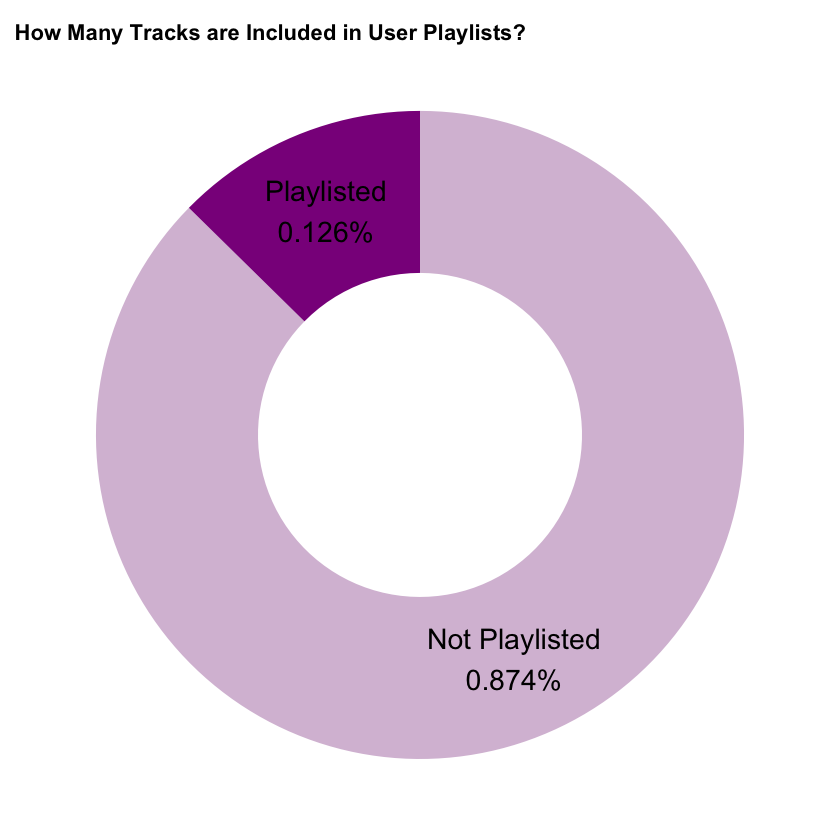

In [35]:
x<-as.data.frame(xtabs(~df$playlist_exposure))%>%mutate(df.playlist_exposure = factor(df.playlist_exposure,labels = c("Not Playlisted", "Playlisted")))
x$prop<-x$Freq/sum(x$Freq)
x$ymax = cumsum(x$prop) 
x$ymin = c(0, head(x$ymax, n=-1)) 
x$labelPosition <- (x$ymax + x$ymin) / 2 
x$label <- paste0(x$df.playlist_exposure,"\n", round(x$prop,3),"%")


ggplot(x, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=df.playlist_exposure)) +
     geom_rect() +
     scale_fill_manual("", values = c("Not Playlisted" = "thistle", "Playlisted" = "darkmagenta"))+
     geom_text( x=3.5, aes(y=labelPosition, label=label), color='black', size=6) +
     coord_polar(theta="y") + 
     xlim(c(2, 4))+
     theme_void()+
     theme(plot.title = element_text(vjust=-2,face='bold'),
     legend.position="none")+
     ggtitle("How Many Tracks are Included in User Playlists?")

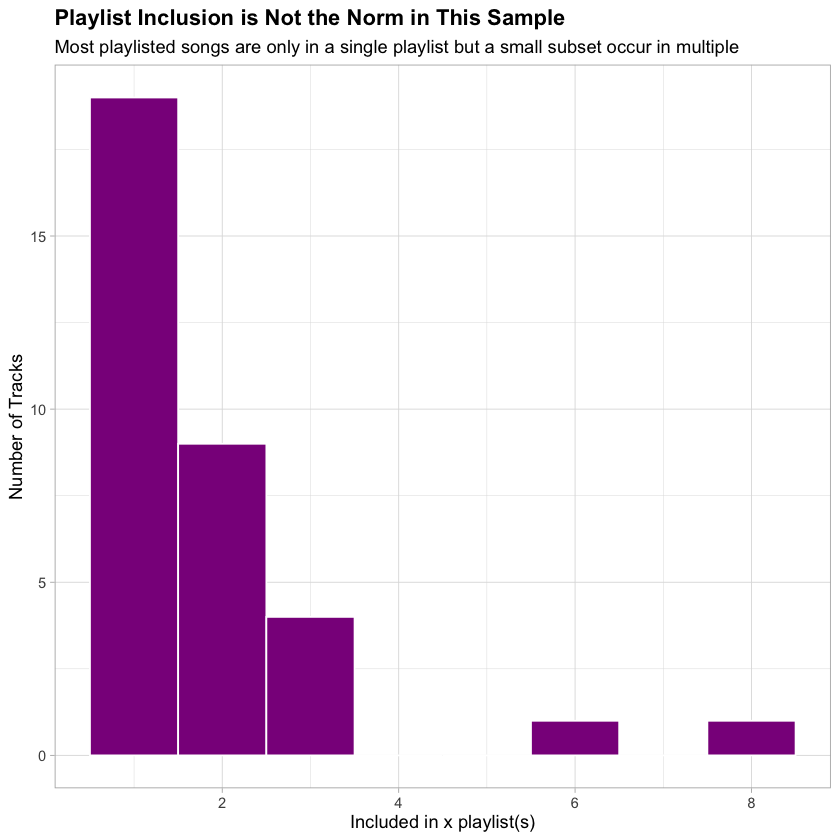

In [36]:
q<-df%>%filter(playlist_exposure==1)
ggplot(q, aes(x = user_playlist_count)) +
  geom_histogram(binwidth = 1, fill = "darkmagenta", color = "white") +
  labs(
    title = "Playlist Inclusion is Not the Norm in This Sample",
    subtitle="Most playlisted songs are only in a single playlist but a small subset occur in multiple",
    x = "Included in x playlist(s)",
    y = "Number of Tracks"
  ) +
  theme_light()+
  theme(plot.title = element_text(face='bold'))

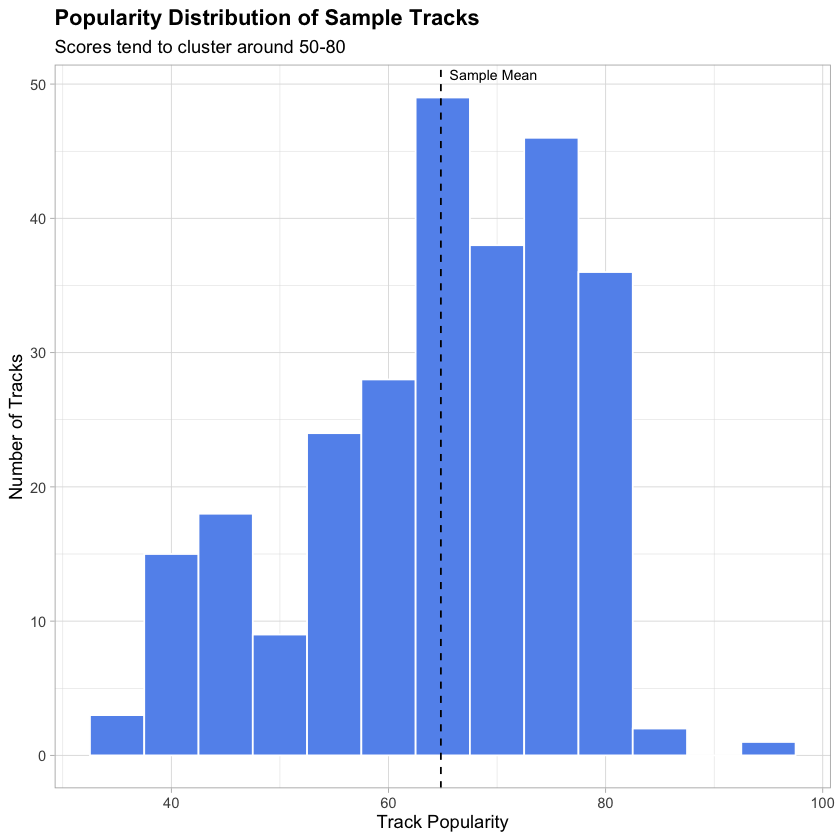

In [37]:
ggplot(df, aes(x = popularity)) +
  geom_histogram(binwidth = 5, fill = "cornflowerblue", color = "white") +
  geom_vline(xintercept = mean(df$popularity), linetype = "dashed") +
  annotate("text",x = mean(df$popularity),y = Inf,label = "Sample Mean",vjust = 1.5,hjust = -0.1,size = 3)+
  labs(
    title = "Popularity Distribution of Sample Tracks",
    subtitle="Scores tend to cluster around 50-80",
    x = "Track Popularity",
    y = "Number of Tracks"
  ) +
  theme_light()+
  theme(plot.title = element_text(face='bold'))

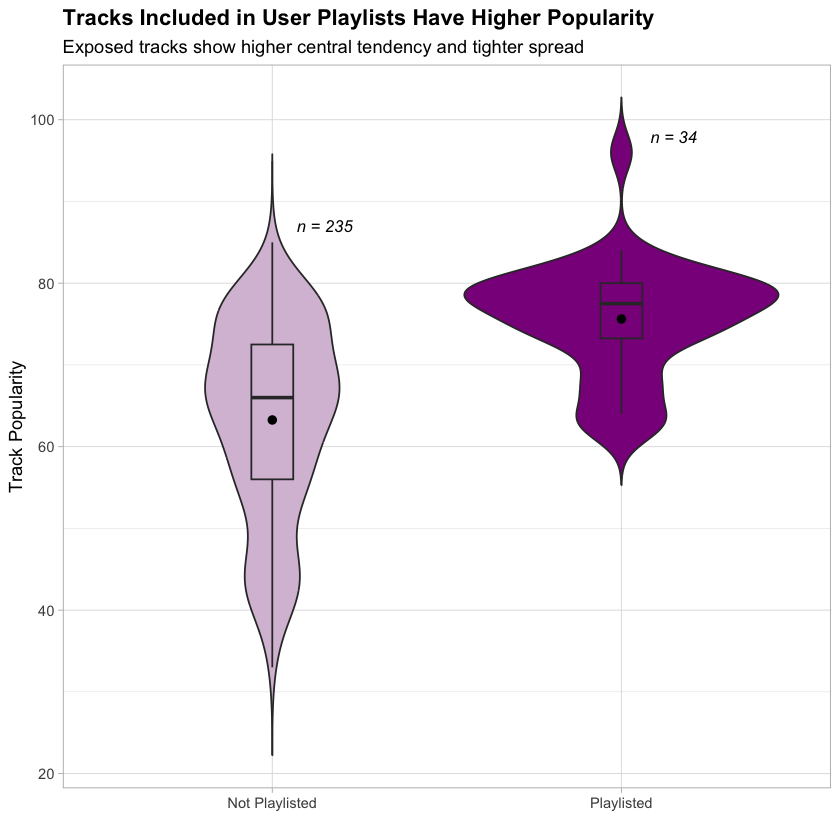

In [38]:
h<- df %>%mutate(playlist_exposure = factor(playlist_exposure,labels = c("Not Playlisted", "Playlisted")))

ggplot(h,aes(x = playlist_exposure, y = popularity, fill = playlist_exposure)) +
  geom_violin(trim=FALSE) +
  geom_boxplot(width = 0.12, alpha = 0.3, outlier.shape = NA) +
  scale_fill_manual("", values = c("Not Playlisted" = "thistle", "Playlisted" = "darkmagenta"))+
  stat_summary(fun = mean, geom = "point", size = 2) +
  geom_text(
     data = h%>%count(playlist_exposure),
     aes(x = playlist_exposure,y = tapply(h$popularity, h$playlist_exposure, max)[playlist_exposure] + 2,label = paste0("n = ", n)),
     position = position_nudge(x = 0.15),size = 3.5,
     fontface='italic')+
  labs(
    title = "Tracks Included in User Playlists Have Higher Popularity",
    subtitle="Exposed tracks show higher central tendency and tighter spread",
    x = "",
    y = "Track Popularity"
  ) +
  theme_light() +
  theme(plot.title = element_text(face='bold'),
  legend.position = "none")


`summarise()` has grouped output by 'big4'. You can override using the
`.groups` argument.


big4,company_total,playlist_exposure,count_play,prop_pref
<fct>,<int>,<fct>,<int>,<dbl>
Not Big 4,109,Not Playlisted,98,0.8990826
Not Big 4,109,Playlisted,11,0.1009174
Big 4,160,Not Playlisted,137,0.8562500
Big 4,160,Playlisted,23,0.1437500


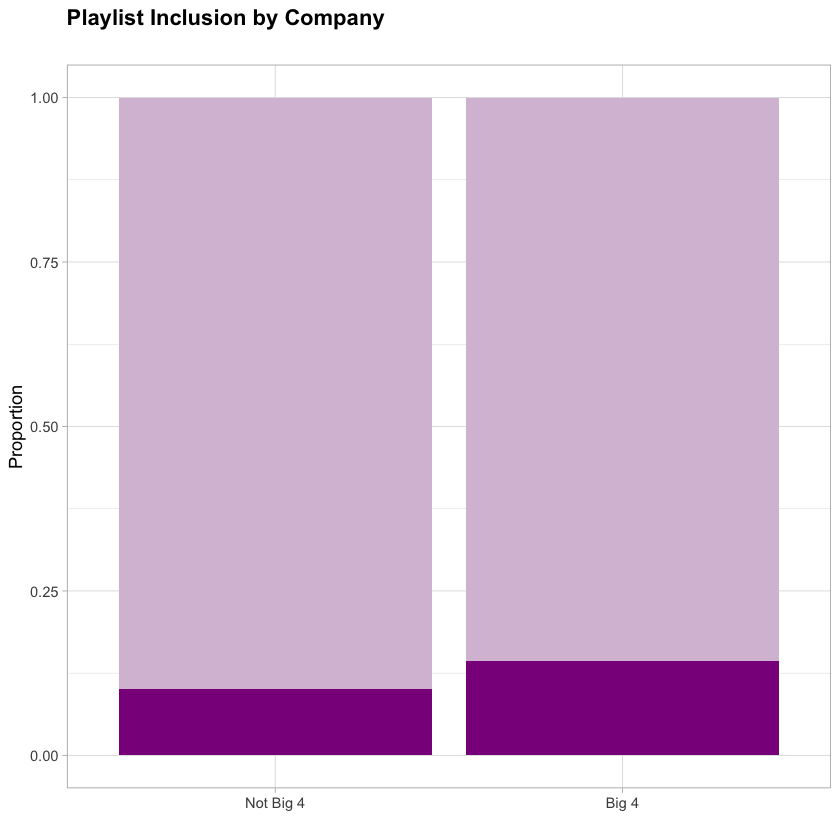

In [39]:
d<-df%>% group_by(big4)%>%summarize(company_total=n())
z<-df%>%group_by(big4,playlist_exposure)%>% summarize(count_play=n())
dz<-merge(d,z,by='big4')%>% mutate(prop_pref=count_play/company_total)%>%mutate(playlist_exposure = factor(playlist_exposure,labels = c("Not Playlisted", "Playlisted")))
dz<-dz%>%mutate(big4=factor(big4,labels=c("Not Big 4","Big 4")))

dz

ggplot(dz, aes(x = big4, y = prop_pref,fill=playlist_exposure)) +
  geom_bar(stat = "identity",position='stack')+
  scale_fill_manual("Playlist Inclusion?", values = c("Not Playlisted" = "thistle", "Playlisted" = "darkmagenta"))+
  theme_light()+
  labs(title='Playlist Inclusion by Company',
  subtitle='',
  x = "",y = "Proportion")+
  theme(plot.title = element_text(face='bold'),
  legend.position = "none")

In [40]:
#getting playlisted counts and totals for companies
la<-df %>%
group_by(company,playlist_exposure) %>%
summarize(count=n(), .groups = "drop") %>%
group_by(company) %>%
mutate(company_total = sum(count)) %>%
ungroup()

la<-cbind(big4=c('HYBE','HYBE','HYBE','HYBE','HYBE','HYBE','Other','Other','Other','Other','Other','JYP','JYP','HYBE','Other','Other','Other','HYBE','HYBE','SM','SM','Other','HYBE','HYBE','Other','Other','Other','YG','YG'),la)
la <- la %>%mutate(big4_exposure = interaction(big4, playlist_exposure, sep = "_"))
la<-la %>%arrange(big4, desc(company_total), company) %>% mutate(index_col = row_number())

# coded big4 designation
for (i in 1:nrow(la)){
  if (la[i,'big4']=='Other'){
    la[i,'big_code']=0
  }
  else{
    la[i,'big_code']=1
  }
}

#ordering
company_order <- la %>%
  distinct(company, big_code, company_total) %>%
  arrange(big_code, desc(company_total), company) %>%
  mutate(index_col = row_number())


la <- la %>%
  left_join(
   company_order %>% select(company, index_col),
    by = "company"
  )
  
la

big4,company,playlist_exposure,count,company_total,big4_exposure,index_col.x,big_code,index_col.y
<chr>,<chr>,<fct>,<int>,<int>,<fct>,<int>,<dbl>,<int>
HYBE,Big Hit Music,0,17,20,HYBE_0,1,1,10
HYBE,Big Hit Music,1,3,20,HYBE_1,2,1,10
HYBE,ADOR,0,9,10,HYBE_0,3,1,13
HYBE,ADOR,1,1,10,HYBE_1,4,1,13
HYBE,Belift Lab,0,9,10,HYBE_0,5,1,14
HYBE,Belift Lab,1,1,10,HYBE_1,6,1,14
HYBE,KOZ Entertainment,0,10,10,HYBE_0,7,1,15
HYBE,Pledis Entertainment,0,9,10,HYBE_0,8,1,16
HYBE,Pledis Entertainment,1,1,10,HYBE_1,9,1,16


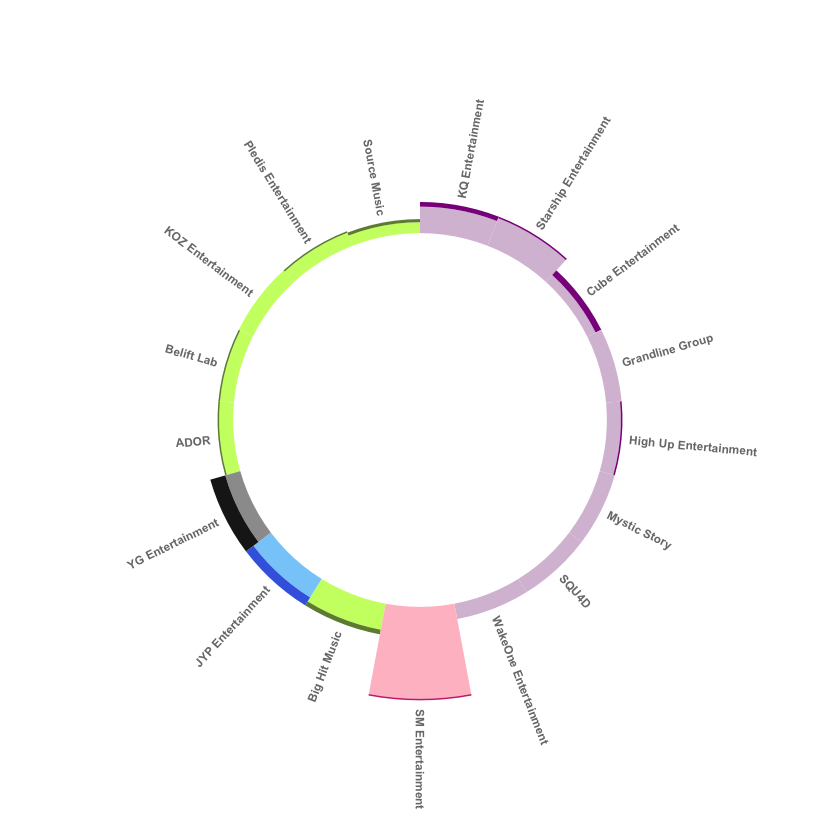

In [41]:
#lab is for labeling. la is for the
lab <- la %>%
  distinct(company, index_col.y, company_total, big4) %>%
  arrange(index_col.y)

##coloring
colors=c("HYBE_0" = "darkolivegreen1",
"HYBE_1"="darkolivegreen4", 
"JYP_0" = "lightskyblue", 
"JYP_1"="royalblue",
"SM_0" = "pink",
"SM_1"="violetred3",
"YG_0"='gray61',
"YG_1"="gray11",
"Other_0"='thistle',
"Other_1"="darkmagenta")

#labelling
number_of_bar <- nrow(lab)
lab <- lab %>%
  mutate(
    angle = 90 - 360 * (index_col.y - 0.5) / number_of_bar,
    h = ifelse(angle < -90, 1, 0),
    angle = ifelse(angle < -90, angle + 180, angle)
  )

p <- ggplot(la, aes(x=as.factor(index_col.y), y=count,fill=big4_exposure)) +       
  geom_bar(stat="identity",position=position_stack(reverse=TRUE),width=1) +
  scale_fill_manual("Big 4 x Playlist Exposure",values = colors,
  labels = c("HYBE_0" = "HYBE  Not Included",
  "HYBE_1" = "HYBE Included",
      "JYP_0"  = "JYP Not Included",
      "JYP_1"  = "JYP Included",
      "SM_0"   = "SM Not Included",
      "SM_1"   = "SM Included",
      "YG_0"   = "YG Not Included",
      "YG_1"   = "YG Included",
      "Other_0"= "Other Not Included",
      "Other_1"= "Other Included"
    ))+
  guides(fill = guide_legend(ncol = 2))+
  ylim(-120,120) + 
  theme_minimal() +   
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    legend.position = 'none',        
    legend.justification = c("center", "center"),
    plot.margin = unit(rep(-1,4), "cm") ) + 
  coord_polar(start=0) +
  geom_text(data=lab, aes(x=index_col.y, y=company_total+5, label=company, hjust=h), color="black", fontface="bold",alpha=0.6, size=2.5, angle= lab$angle, inherit.aes = FALSE )
 
p

`summarise()` has grouped output by 'playlist_exposure'. You can override using
the `.groups` argument.


playlist_exposure,gender,count,gender_total,prop
<fct>,<fct>,<int>,<int>,<dbl>
Not Playlisted,F,114,139,0.82014388
Not Playlisted,M,121,130,0.93076923
Playlisted,F,25,139,0.17985612
Playlisted,M,9,130,0.06923077


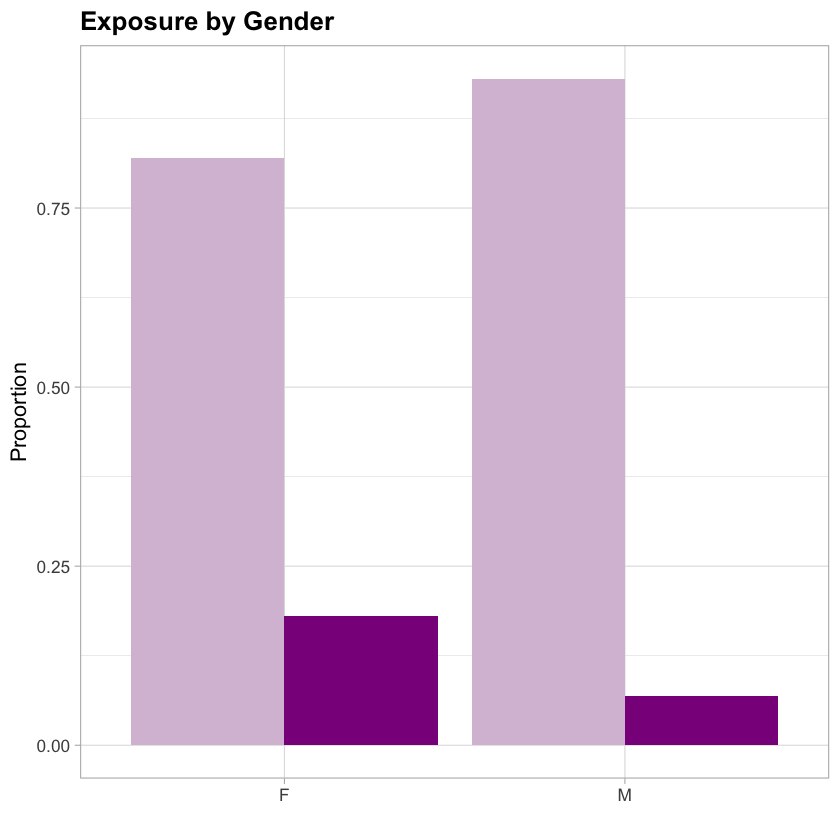

In [42]:
pla <- df %>%group_by(playlist_exposure, gender) %>%summarise(count=n())
pla<-pla %>% group_by(gender)%>%mutate(gender_total=sum(count,na.rm=TRUE))
pla<-pla%>%mutate(prop=count/gender_total)%>%mutate(playlist_exposure = factor(playlist_exposure,labels = c("Not Playlisted", "Playlisted")))
#pla<-pla%>%mutate(gender = factor(playlist_exposure,labels = c("Girl Group", "Boy Group")))
pla
ggplot(pla, aes(x = gender, y = prop, 
                     fill = factor(playlist_exposure))) +
  geom_col(position = "dodge") +
  scale_fill_manual("",values = c("Playlisted"='darkmagenta','Not Playlisted'='thistle'))+
  labs(
    title = "Exposure by Gender",
    x = "",
    y = "Proportion"
  ) +
  theme_light(base_size=13)+
  theme(
  plot.title = element_text(face='bold'),
  legend.position = "none")


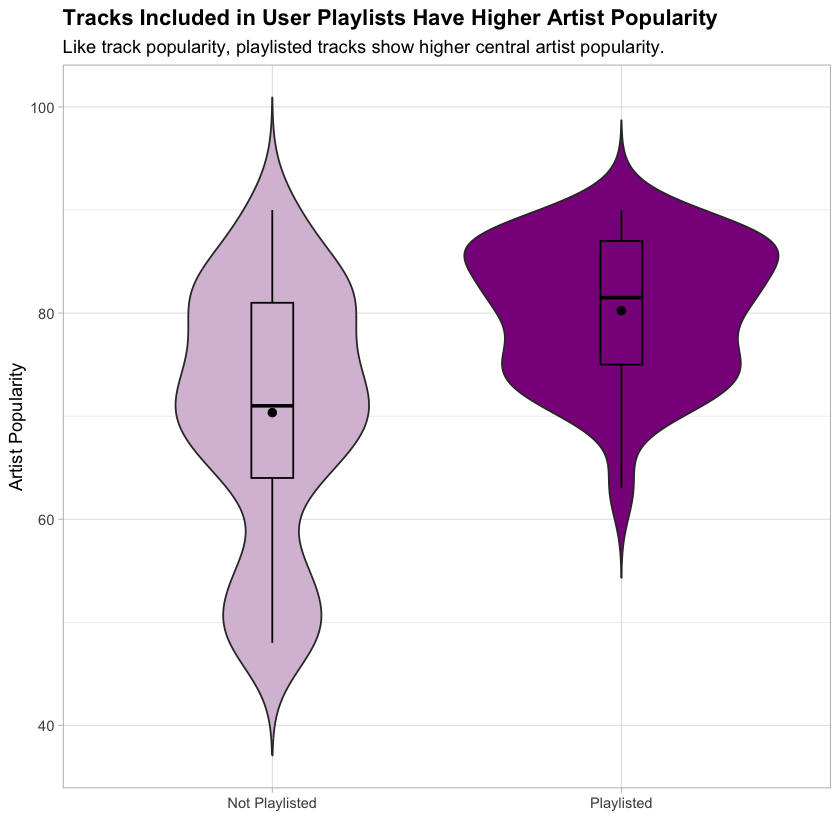

In [43]:
df %>%mutate(playlist_exposure = factor(playlist_exposure,labels = c("Not Playlisted", "Playlisted")))%>%
  ggplot( aes(x=playlist_exposure, y=artist_popularity, fill=playlist_exposure)) +
    geom_violin(trim=FALSE) +
    geom_boxplot(width=0.12, color="black", alpha=0.3,outlier.shape=NA)+
    scale_fill_manual("", values = c("Not Playlisted" = "thistle", "Playlisted" = "darkmagenta")) +
    stat_summary(fun=mean,geom="point",size=2)+
    labs(
    title = "Tracks Included in User Playlists Have Higher Artist Popularity",
    subtitle="Like track popularity, playlisted tracks show higher central artist popularity.",
    x = "",
    y = "Artist Popularity")+
    theme_light()+
    theme(plot.title = element_text(face='bold'),
      legend.position="none"
    ) 

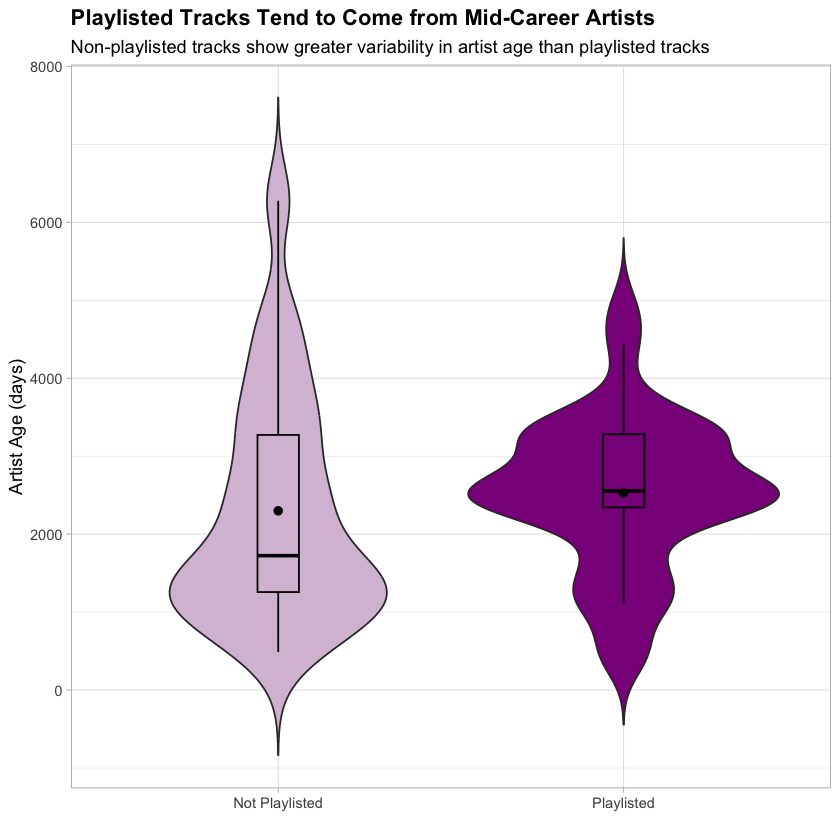

In [44]:
df %>%mutate(playlist_exposure = factor(playlist_exposure,labels = c("Not Playlisted", "Playlisted")))%>%
  ggplot( aes(x=playlist_exposure, y=age_days, fill=playlist_exposure)) +
    geom_violin(trim=FALSE) +
    geom_boxplot(width=0.12, color="black", alpha=0.3,outlier.shape=NA)+
     stat_summary(fun=mean,geom="point",size=2)+
    scale_fill_manual("", values = c("Not Playlisted" = "thistle", "Playlisted" = "darkmagenta")) +
    labs(
    title = "Playlisted Tracks Tend to Come from Mid-Career Artists ",
    subtitle="Non-playlisted tracks show greater variability in artist age than playlisted tracks ",
    x = "",
    y = "Artist Age (days)")+
    theme_light()+
    theme(plot.title = element_text(face='bold'),
      legend.position="none"
    )


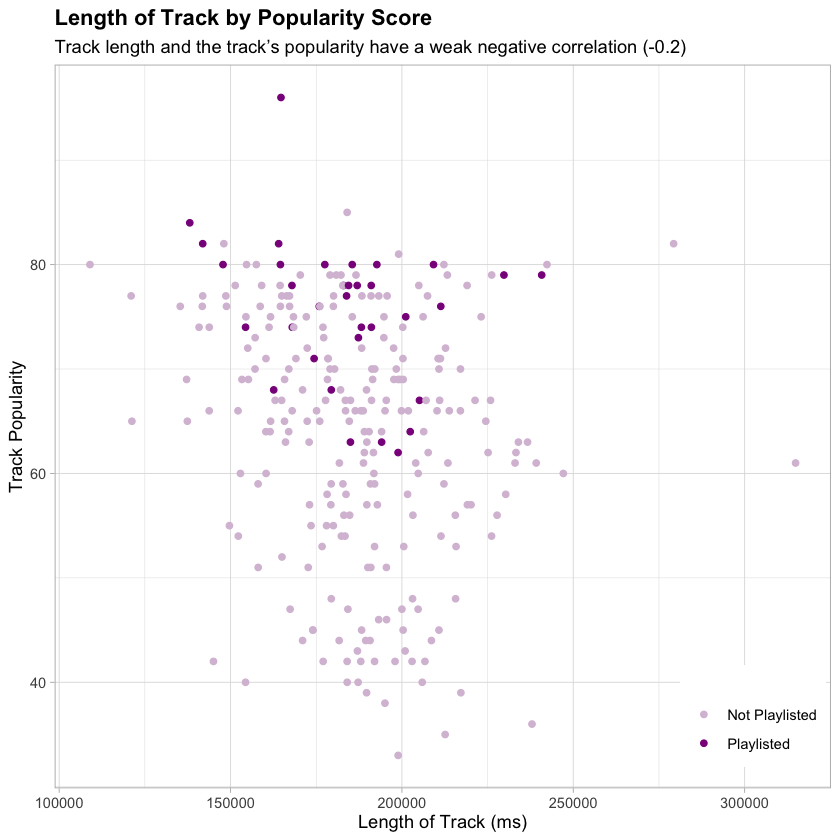

In [45]:
df%>%
mutate(playlist_exposure = factor(playlist_exposure,labels = c("Not Playlisted", "Playlisted")))%>%
ggplot(aes(x=duration_ms, y=popularity,color=playlist_exposure)) + 
    scale_color_manual("", values = c("Not Playlisted" = "thistle", "Playlisted" = "darkmagenta"))+
    geom_point()+
    labs(
        title='Length of Track by Popularity Score',
        subtitle='Track length and the track’s popularity have a weak negative correlation (-0.2)',
        x = "Length of Track (ms)",
        y = "Track Popularity")+
    theme_light()+
    theme(plot.title = element_text(face='bold'),
    legend.position = c(0.9, 0.1))

In [46]:
tapply(df$days_since_release, df$playlist_exposure, summary) 

$`0`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.0   190.5   645.0   998.4  1281.5  6183.0 

$`1`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.0    60.5   755.5   990.9  1765.0  3713.0 


Picking joint bandwidth of 354



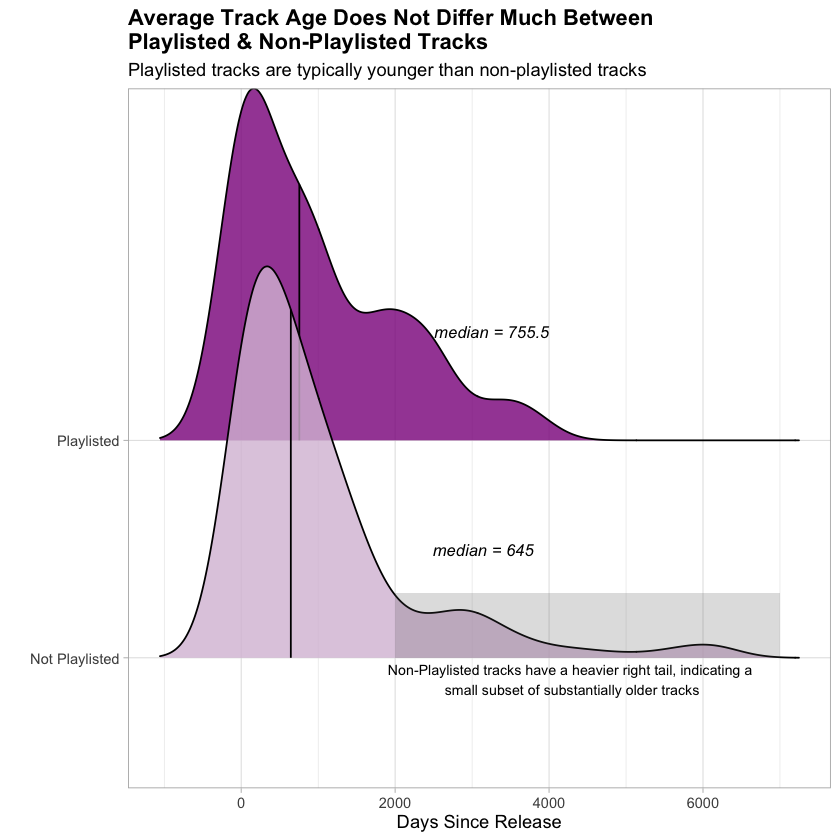

In [47]:
#install.packages('ggridges')
library(ggridges)

df%>%mutate(playlist_exposure = factor(playlist_exposure,labels = c("Not Playlisted", "Playlisted")))%>%
ggplot(aes(x = days_since_release, y = playlist_exposure, fill = playlist_exposure)) +
geom_density_ridges(quantile_lines=TRUE,quantiles=2, alpha=0.8) +
scale_fill_manual("", values = c("Not Playlisted" = "thistle", "Playlisted" = "darkmagenta"))+
geom_text(data = df%>%mutate(playlist_exposure = factor(playlist_exposure,labels = c("Not Playlisted", "Playlisted")))%>%group_by(playlist_exposure)%>%summarize(med_age=median(days_since_release)),
aes(x = tapply(df$days_since_release, df$playlist_exposure, median)[playlist_exposure]+2500,y = playlist_exposure,label = paste0("median = ", med_age)),
position = position_nudge(y=0.5),size = 3.5,fontface='italic')+
annotate("rect", xmin = 2000, xmax = 7000, ymin = 'Not Playlisted', ymax = 1.3,alpha = .2)+
annotate("text", x = 4300, y=0.9,label="Non-Playlisted tracks have a heavier right tail, indicating a \nsmall subset of substantially older tracks",size=3)+
theme_light() + 
labs(title='Average Track Age Does Not Differ Much Between \nPlaylisted & Non-Playlisted Tracks',
    subtitle='Playlisted tracks are typically younger than non-playlisted tracks',
    x = "Days Since Release",
    y = "")+
theme(legend.position = "none",
plot.title = element_text(face='bold'))

# What Features (if any) Contribute to the Likelihood of Being Included on a User Curated Playlist?

In [48]:
set.seed(100)
split = sample.split(df$playlist_exposure, SplitRatio = 0.8)
train = subset(df, split == TRUE)
test = subset(df, split == FALSE)
rownames(train) <- NULL
rownames(test)<-NULL

### **Baseline Logistic** 

In [49]:
set.seed(100)
#features only cut out user playlist count as this is always non zero if exposure is 1
model<-glm(playlist_exposure~duration_ms+popularity+artist_followers+artist_popularity+big4+gender+days_since_release+age_days+collab+genre_noise_music+genre_k_rock,family = binomial(link=logit),data=train)

summary(model)


Call:
glm(formula = playlist_exposure ~ duration_ms + popularity + 
    artist_followers + artist_popularity + big4 + gender + days_since_release + 
    age_days + collab + genre_noise_music + genre_k_rock, family = binomial(link = logit), 
    data = train)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.919e+01  6.356e+00  -3.020  0.00253 ** 
duration_ms        -2.587e-06  1.121e-05  -0.231  0.81753    
popularity          4.049e-01  9.885e-02   4.096 4.21e-05 ***
artist_followers    8.544e-09  2.369e-08   0.361  0.71837    
artist_popularity  -1.571e-01  9.100e-02  -1.727  0.08419 .  
big41              -1.514e+00  6.989e-01  -2.166  0.03031 *  
genderM            -1.778e+00  7.761e-01  -2.292  0.02193 *  
days_since_release -1.470e-04  3.600e-04  -0.408  0.68305    
age_days            8.713e-04  4.350e-04   2.003  0.04520 *  
collab1             7.453e-01  8.855e-01   0.842  0.40000    
genre_noise_music1 -3.482e-02  9.273e-01  -

In [50]:
exp(coef(model))

(Intercept)        duration_ms         popularity   artist_followers 
      4.616275e-09       9.999974e-01       1.499089e+00       1.000000e+00 
 artist_popularity              big41            genderM days_since_release 
      8.545865e-01       2.200829e-01       1.689038e-01       9.998530e-01 
          age_days            collab1 genre_noise_music1      genre_k_rock1 
      1.000872e+00       2.107035e+00       9.657834e-01       7.858305e-05

In [51]:
vif(model)
#makes sense as artist popularity is some mix of track popularity, follower counts
#days since release is likely to be related with age as older groups are likely to have older songs
# but as all of these are less than 10, likely to be no concerning amount of multicollinearity

duration_ms         popularity   artist_followers  artist_popularity 
          1.731814           4.146164           5.357664           6.726428 
              big4             gender days_since_release           age_days 
          1.629124           1.907170           2.350540           4.828022 
            collab  genre_noise_music       genre_k_rock 
          1.145218           1.727172           1.000004

In [52]:
# test for overall regression -- at least one of the variables can help to explain
gstat <- model$null.deviance - deviance(model)
cbind(gstat, 1 - pchisq(gstat, length(coef(model)) - 1))

gstat,
63.12531,2.422597e-09


## **Standardized & Transformed Logistic Regression**

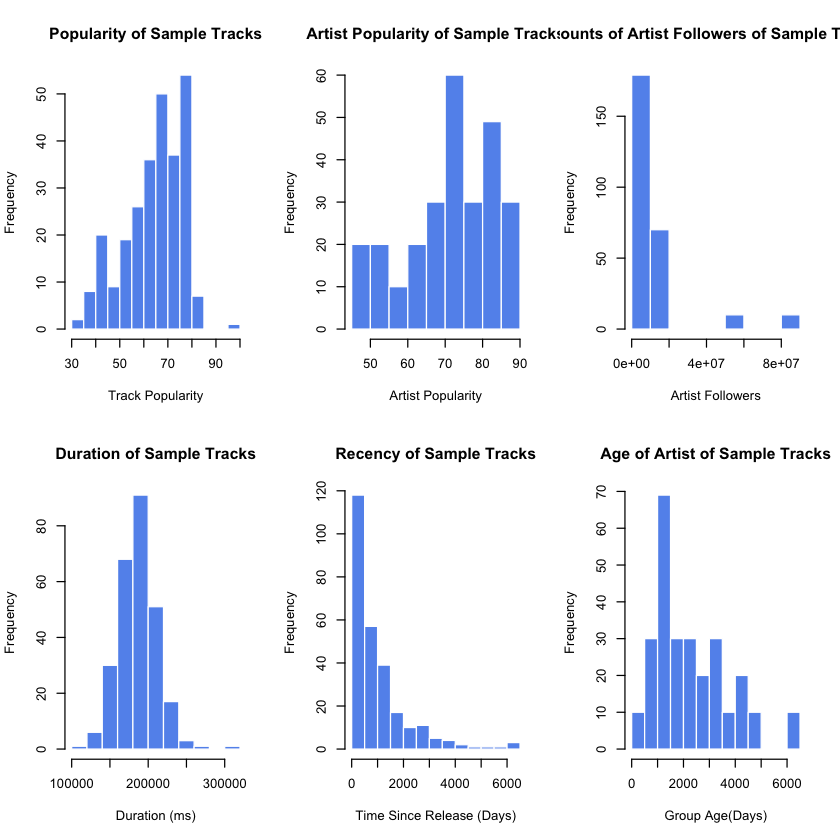

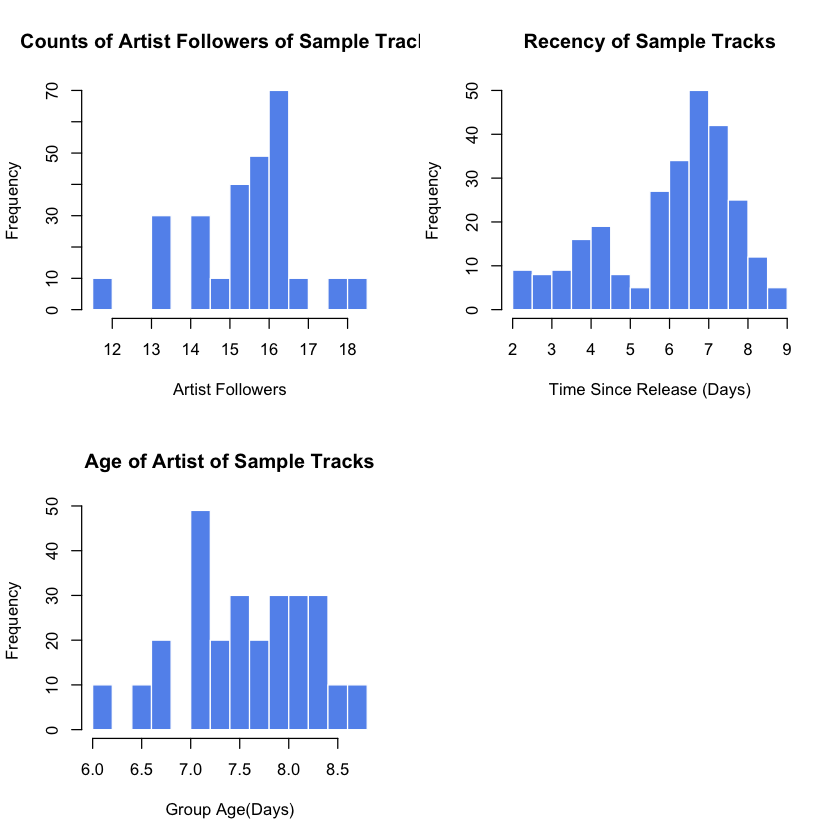

In [53]:
#histograms of continouse factors
par(mfrow = c(2, 3))
hist(df$popularity,main = "Popularity of Sample Tracks",xlab = "Track Popularity",col='cornflowerblue',border='white')
hist(df$artist_popularity,main = "Artist Popularity of Sample Tracks",xlab = "Artist Popularity",col='cornflowerblue',border='white')
hist(df$artist_followers,main = "Counts of Artist Followers of Sample Tracks",xlab = "Artist Followers",col='cornflowerblue',border='white')#right skew
hist(df$duration_ms,main = "Duration of Sample Tracks",xlab = "Duration (ms)",col='cornflowerblue',border='white')#normal
hist(df$days_since_release,main = "Recency of Sample Tracks",xlab = "Time Since Release (Days)",col='cornflowerblue',border='white')#right skew
hist(df$age_days,main = "Age of Artist of Sample Tracks",xlab = "Group Age(Days)",col='cornflowerblue',border='white') #kind of right skew

par(mfrow = c(2, 2))
#double check usefulness of log transformation
hist(log(df$artist_followers),main = "Counts of Artist Followers of Sample Tracks",xlab = "Artist Followers",col='cornflowerblue',border='white')#right skew
hist(log(df$days_since_release),main = "Recency of Sample Tracks",xlab = "Time Since Release (Days)",col='cornflowerblue',border='white')#right skew
hist(log(df$age_days),main = "Age of Artist of Sample Tracks",xlab = "Group Age(Days)",col='cornflowerblue',border='white') #kind of right skew

In [55]:
#standardizing and transforming the train/test sets
library(recipes)

rec <- recipe(playlist_exposure ~ ., data = train) %>%
  step_log(age_days, days_since_release, artist_followers, offset = 1) %>%
  step_normalize(all_numeric_predictors())

prep <- prep(rec, training = train)

train_processed <- bake(prep, new_data = train)
test_processed  <- bake(prep, new_data = test)

In [56]:
set.seed(100)
#features only cut out user playlist count as this is always non zero if exposure is 1
mod2<-glm(playlist_exposure~duration_ms+popularity+artist_followers+artist_popularity+big4+gender+days_since_release+age_days+collab+genre_noise_music+genre_k_rock,family = binomial(link=logit),data=train_processed)

summary(mod2)


Call:
glm(formula = playlist_exposure ~ duration_ms + popularity + 
    artist_followers + artist_popularity + big4 + gender + days_since_release + 
    age_days + collab + genre_noise_music + genre_k_rock, family = binomial(link = logit), 
    data = train_processed)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -2.73263    0.71275  -3.834 0.000126 ***
duration_ms          -0.03245    0.27884  -0.116 0.907365    
popularity            5.09988    1.27831   3.990 6.62e-05 ***
artist_followers      0.92842    1.71847   0.540 0.589021    
artist_popularity    -2.56119    1.80747  -1.417 0.156482    
big41                -1.49035    0.77816  -1.915 0.055465 .  
genderM              -2.15937    0.97753  -2.209 0.027175 *  
days_since_release   -0.51357    0.35890  -1.431 0.152436    
age_days              1.29517    0.75552   1.714 0.086477 .  
collab1               0.73886    0.90518   0.816 0.414352    
genre_noise_music1   -0.35518    

In [57]:
vif(mod2)

duration_ms         popularity   artist_followers  artist_popularity 
          1.459096           4.049330          19.481486          15.350447 
              big4             gender days_since_release           age_days 
          1.895768           2.770629           2.059802           5.720294 
            collab  genre_noise_music       genre_k_rock 
          1.174570           2.342807           1.000005

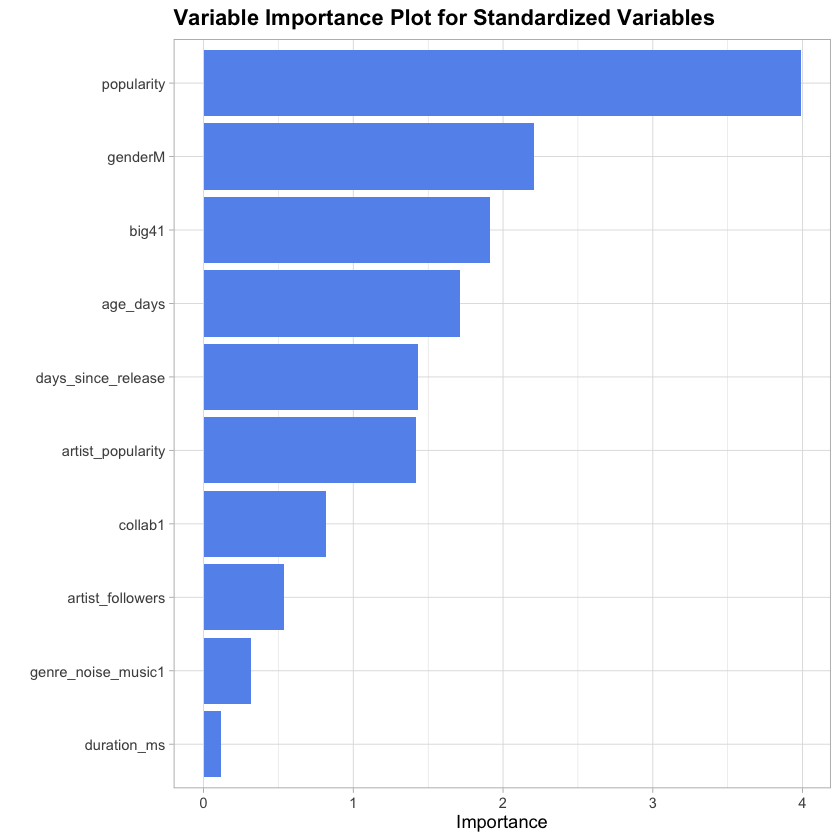

In [58]:
v <- vi(mod2)
v$Sign <- ifelse(v$Importance > 0, "Positive", "Negative")

vip(v, mapping = aes(fill = "Sign"))+
scale_fill_manual("",values="cornflowerblue")+
labs(title='Variable Importance Plot for Standardized Variables')+
theme_light()+
theme(legend.position='none',
plot.title = element_text(face='bold'))

## **Elastic Net (Standardized)**

In [59]:
# variable selection
set.seed(100)
# Set predictors and response to correct format so as to be able to standardize them prior to variable selection
x.train <- model.matrix(playlist_exposure ~ duration_ms+popularity+artist_followers+artist_popularity+big4+gender+days_since_release+age_days+collab+genre_noise_music+genre_k_rock, train)[,-1]
y.train <- train$playlist_exposure

In [60]:
# elastic net
# Use cross validation to find optimal lambda & to standardize
cv.elnet <- cv.glmnet(x.train, y.train, alpha = 0.5, family = "binomial")

# Train Elastic Net and display coefficients with optimal lambda
elnet.model <- glmnet(x.train, y.train, alpha = 0.5, family = "binomial")
coef(elnet.model, cv.elnet$lambda.min)

12 x 1 sparse Matrix of class "dgCMatrix"
                    s=0.00774978
(Intercept)        -1.375444e+01
duration_ms         .           
popularity          1.685705e-01
artist_followers    1.401635e-09
artist_popularity   .           
big41              -8.832805e-01
genderM            -1.121125e+00
days_since_release  .           
age_days            3.106718e-04
collab1             4.655554e-01
genre_noise_music1 -5.704431e-02
genre_k_rock1       .           

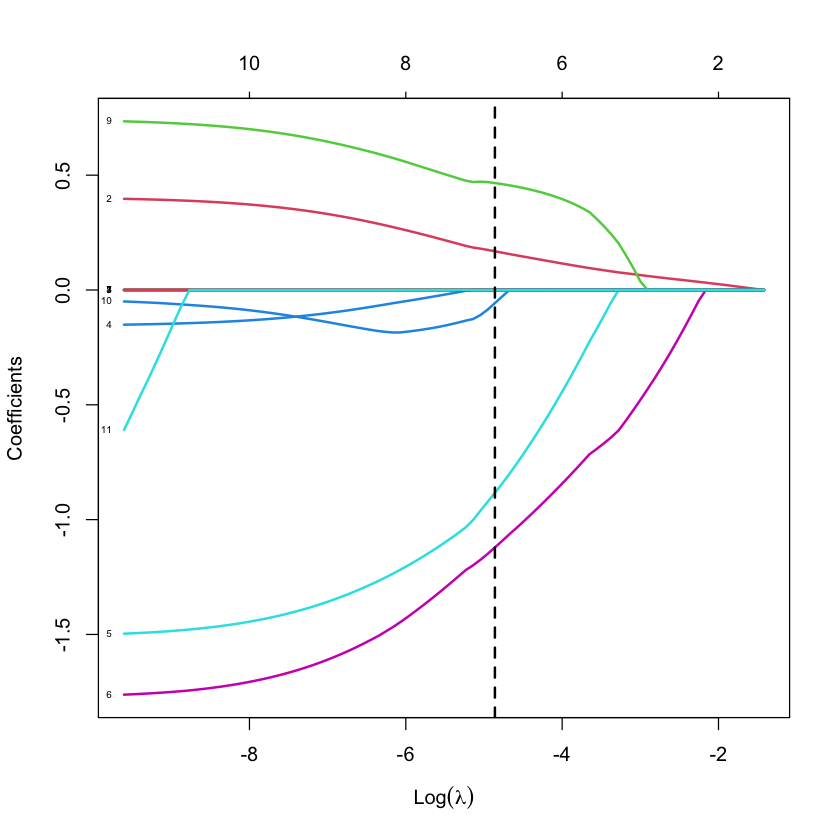

In [61]:
set.seed(100) 
plot(elnet.model, xvar = "lambda", label = TRUE, lwd = 2,sign.lambda = 1)
abline(v=log(cv.elnet$lambda.min),col='black',lty = 2,lwd=2)


In [62]:
exp(coef(elnet.model, cv.elnet$lambda.min))

12 x 1 Matrix of class "dgeMatrix"
                   s=0.00774978
(Intercept)        1.062973e-06
duration_ms        1.000000e+00
popularity         1.183612e+00
artist_followers   1.000000e+00
artist_popularity  1.000000e+00
big41              4.134244e-01
genderM            3.259128e-01
days_since_release 1.000000e+00
age_days           1.000311e+00
collab1            1.592899e+00
genre_noise_music1 9.445522e-01
genre_k_rock1      1.000000e+00

## Comparison

In [63]:
# 1. Prediction for the full logistic regression model
# Obtain predicted probabilities for the test set
pred.full = predict(model, newdata = test,type="response")

# Obtain classifications using a classification threshold of 0.5
predClass.full = ifelse(pred.full > 0.5, 1, 0)

In [64]:
#standardized and transformed data
pred.full2= predict(mod2, newdata=test_processed,type='response')
predClass.full2=ifelse(pred.full2>0.5,1,0)
     

In [65]:
#4. Prediction for elastic net regression 
# Set predictors to correct format
x.test <- model.matrix(playlist_exposure ~ duration_ms+popularity+artist_followers+artist_popularity+big4+gender+days_since_release+age_days+collab+genre_noise_music+genre_k_rock, test)[,-1]
# Obtain predicted probabilities for the test set
pred.elnet = as.vector(predict(elnet.model, newx = x.test,
                               type = "response", s = cv.elnet$lambda.min))
                               
# Obtain classifications using a classification threshold of 0.4
predClass.elnet = ifelse(pred.elnet > 0.5, 1, 0)

In [66]:
# Create a data frame with the predictions
preds = data.frame(playlist_exposure = test$playlist_exposure, predClass.full,predClass.full2, predClass.elnet)

# Build a confusion table and calculate metrics, set 1 as positive class
pred_metrics = function(modelName, predClass, actualClass) {
  cat(modelName, '\n')
  # conmat <- confusionMatrix(table(predClass, actualClass))
  predClass <- factor(predClass, levels = c("0", "1"))
  actualClass <- factor(actualClass, levels = c("0", "1"))
  conmat <- confusionMatrix(predClass, actualClass, positive="1")
  c(round(conmat$overall["Accuracy"],4), round(conmat$byClass["Sensitivity"],4),
    round(conmat$byClass["Specificity"],4))
}

pred_metrics("Full Model", predClass.full, test$playlist_exposure)
pred_metrics("Standardized Model", predClass.full2,test_processed$playlist_exposure)
pred_metrics("Elastic Regression Model", predClass.elnet, test$playlist_exposure)



Full Model 


Accuracy Sensitivity Specificity 
     0.8704      0.1429      0.9787

Standardized Model 


Accuracy Sensitivity Specificity 
     0.8704      0.1429      0.9787

Elastic Regression Model 


Accuracy Sensitivity Specificity 
     0.8704      0.0000      1.0000

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



  Full.Model.AUC Standardized.AUC Elastic.Net.AUC
1         0.6778           0.7204          0.7204


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



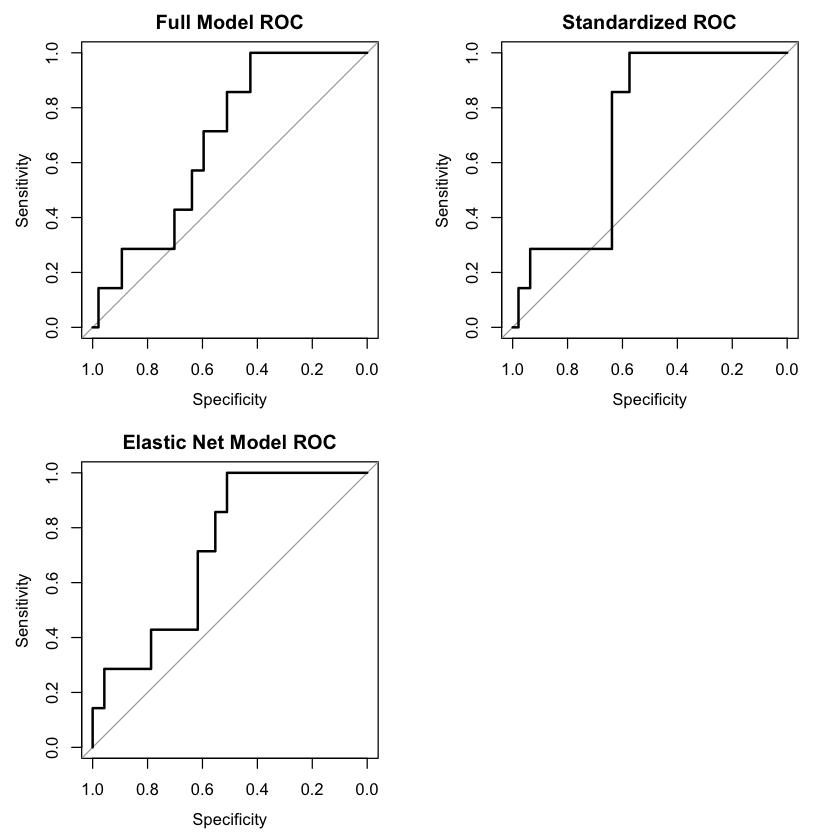

In [67]:
auc.full=auc(test$playlist_exposure,pred.full)
auc.std=auc(test_processed$playlist_exposure,pred.full2)
auc.elnet=auc(test$playlist_exposure,pred.elnet)


auc_results <-data.frame('Full Model AUC' = auc.full,
'Standardized AUC' = auc.std,
'Elastic Net AUC' = auc.elnet
)
auc_results <- round(auc_results, 4)  
print(auc_results)

#plot
par(mfrow=c(2,2))
plot(roc(test$playlist_exposure,pred.full),main='Full Model ROC')
plot(roc(test_processed$playlist_exposure,pred.full2),main='Standardized ROC')
plot(roc(test$playlist_exposure,pred.elnet),main='Elastic Net Model ROC')

# Do Engagement  Differences Survive After Controlling for Track Characteristics?

## **Adjusted Regression**

In [68]:
a<-lm(popularity~playlist_exposure,data=df)
summary(a)


Call:
lm(formula = popularity ~ playlist_exposure, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.264  -7.264   2.382   7.736  21.736 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         63.2638     0.7436  85.079  < 2e-16 ***
playlist_exposure1  12.3538     2.0916   5.906 1.06e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.4 on 267 degrees of freedom
Multiple R-squared:  0.1156,	Adjusted R-squared:  0.1122 
F-statistic: 34.89 on 1 and 267 DF,  p-value: 1.06e-08


In [71]:
b<-lm(popularity~playlist_exposure+duration_ms+artist_followers+big4+gender+days_since_release+age_days+collab+genre_noise_music+genre_k_rock,data=df)
summary(b)


Call:
lm(formula = popularity ~ playlist_exposure + duration_ms + artist_followers + 
    big4 + gender + days_since_release + age_days + collab + 
    genre_noise_music + genre_k_rock, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.0064  -5.8312   0.3998   5.4879  19.0010 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         8.084e+01  4.364e+00  18.523  < 2e-16 ***
playlist_exposure1  6.917e+00  1.646e+00   4.201 3.66e-05 ***
duration_ms        -1.308e-04  2.485e-05  -5.263 2.98e-07 ***
artist_followers    2.332e-07  3.704e-08   6.295 1.31e-09 ***
big41               1.049e+01  1.320e+00   7.953 5.74e-14 ***
genderM            -3.056e+00  1.346e+00  -2.271    0.024 *  
days_since_release  1.465e-04  6.832e-04   0.214    0.830    
age_days            3.341e-05  6.223e-04   0.054    0.957    
collab1             1.241e+00  2.740e+00   0.453    0.651    
genre_noise_music1  2.359e-01  1.515e+00   0.156    0.876    
g

In [88]:
confint(b,level=0.95)

,2.5 %,97.5 %
(Intercept),7.224590e+01,8.943407e+01
playlist_exposure1,3.674709e+00,1.015854e+01
duration_ms,-1.797424e-04,-8.186063e-05
artist_followers,1.602526e-07,3.061474e-07
big41,7.896120e+00,1.309341e+01
genderM,-5.706070e+00,-4.061712e-01
days_since_release,-1.198902e-03,1.491835e-03
age_days,-1.192114e-03,1.258942e-03
collab1,-4.153958e+00,6.635939e+00
genre_noise_music1,-2.747149e+00,3.219011e+00


In [ ]:
#install.packages('dotwhisker')
library(dotwhisker)

also installing the dependencies ‘patchwork’, ‘ggstance’, ‘marginaleffects’





The downloaded binary packages are in
	/var/folders/ht/qs8tmmy5007cstwcxtpn4zjr0000gn/T//Rtmp001LBz/downloaded_packages


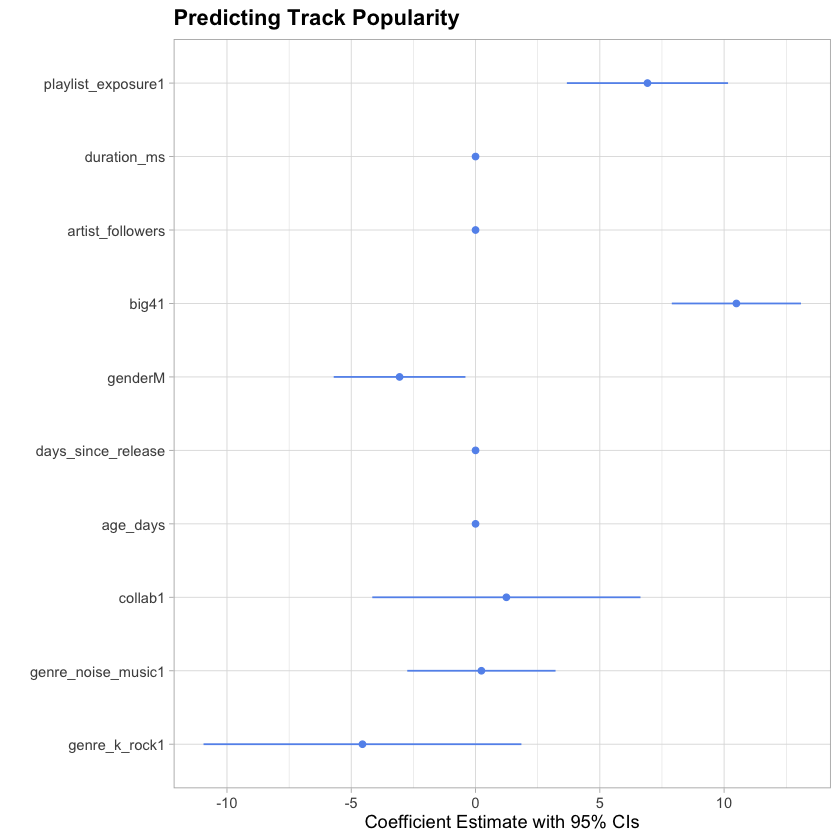

In [89]:
dwplot(b,dot_args = list(color = "cornflowerblue"),whisker_args = list(color = "cornflowerblue")) +
  theme_light() +
  scale_color_discrete()+
  labs(title = "Predicting Track Popularity",
       x = "Coefficient Estimate with 95% CIs",
       y = "")+
  theme(legend.position='none',plot.title = element_text(face='bold'))

In [ ]:
#standardized and log transformed

s <- recipe(playlist_exposure ~ ., data = df) %>%
  step_log(age_days, days_since_release, artist_followers, offset = 1) %>%
  step_normalize(all_numeric_predictors())

prep <- prep(s, training = df)

s_processed <- bake(prep, new_data = df)


In [84]:
bb<-lm(popularity~playlist_exposure+duration_ms+artist_followers+big4+gender+days_since_release+age_days+collab+genre_noise_music+genre_k_rock,data=s_processed)
summary(bb)


Call:
lm(formula = popularity ~ playlist_exposure + duration_ms + artist_followers + 
    big4 + gender + days_since_release + age_days + collab + 
    genre_noise_music + genre_k_rock, data = s_processed)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.46760 -0.33473 -0.00187  0.32858  1.60395 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -0.11529    0.05906  -1.952  0.05202 .  
playlist_exposure1  0.27671    0.09283   2.981  0.00315 ** 
duration_ms        -0.10967    0.03434  -3.193  0.00158 ** 
artist_followers    0.89556    0.04489  19.951  < 2e-16 ***
big41               0.16130    0.08345   1.933  0.05434 .  
genderM             0.05067    0.07839   0.646  0.51862    
days_since_release -0.08463    0.03497  -2.420  0.01620 *  
age_days           -0.23066    0.04195  -5.498 9.24e-08 ***
collab1            -0.17723    0.15100  -1.174  0.24160    
genre_noise_music1 -0.15932    0.08319  -1.915  0.05658 .  
genre_k_rock1 

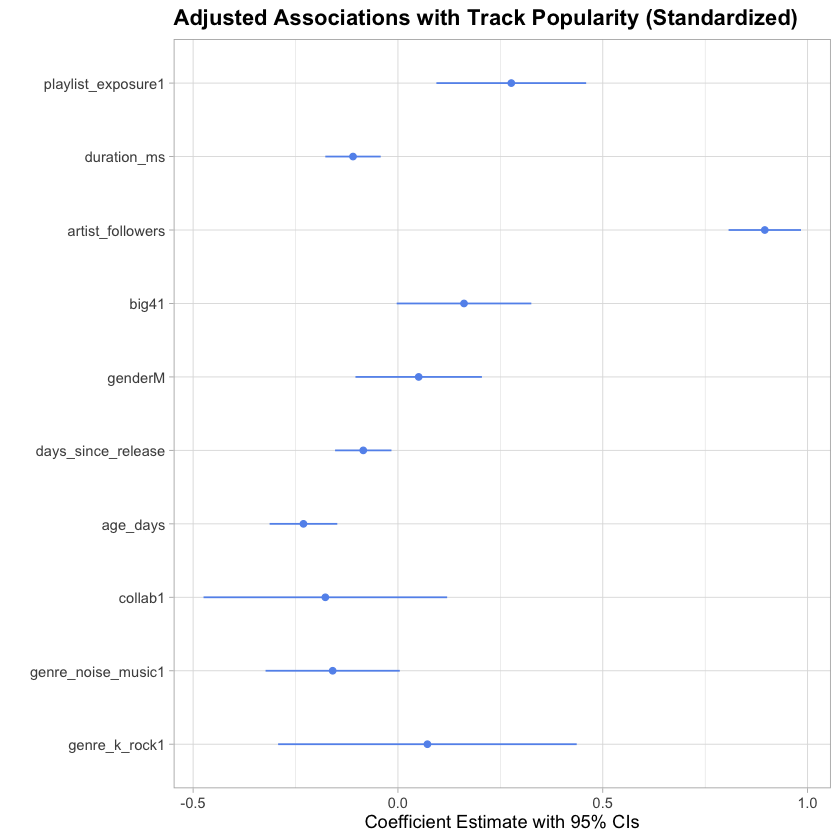

In [90]:
dwplot(bb,dot_args = list(color = "cornflowerblue"),whisker_args = list(color = "cornflowerblue")) +
  theme_light() +
  scale_color_discrete()+
  labs(title = "Adjusted Associations with Track Popularity (Standardized)",
       x = "Coefficient Estimate with 95% CIs",
       y = "")+
  theme(legend.position='none',plot.title = element_text(face='bold'))